# MLP class

In [131]:
import numpy as np

In [132]:
import copy

class MLP:
    def __init__(self, layer_sizes, act_fun='sigmoid', out_act_fun_name = 'linear', loss_fun_name = 'mse', metric = 'mse'):
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes)
        self.set_act_fun(act_fun)
        self.set_out_act_fun(out_act_fun_name)
        self.set_loss_fun(loss_fun_name)
        self.metric = metric
        
        self.weights = [None] * (self.n_layers - 1)
        self.biases = [None] * (self.n_layers - 1)
        self.initialize_weights()

    def initialize_weights(self):
        for i in range(self.n_layers - 1):
            self.weights[i] = np.random.rand(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.biases[i] = np.random.rand(self.layer_sizes[i + 1], 1)        

    def _forward(self, X, return_activations = False, return_probabilities = True):
        X = np.atleast_2d(X)
        if X.shape[0] == 1:
            X = X.reshape(-1, 1)
        Y = X
        if return_activations: A = []

        for i in range(self.n_layers - 2):
            Y = np.dot(Y, self.weights[i]) + self.biases[i].T
            if return_activations:
                A.append(Y)
            Y = self.act_fun(Y)
        Y = np.dot(Y, self.weights[-1]) + self.biases[-1].T
        if return_activations:
            A.append(Y)
        Y = self.out_act_fun(Y)
        if not return_probabilities and self.out_act_fun_name == 'softmax':
            Y = np.argmax(Y, axis=1)
        return Y if not return_activations else (Y, A)

    def predict(self, X, return_probabilities=True):
        return self._forward(X, return_probabilities=return_probabilities)
    
    def _backward(self, X, Y, batch_size):
        Y = np.atleast_2d(Y)
        X = np.atleast_2d(X)
        if X.shape[0] == 1:
            X = X.reshape(-1, 1)
        if Y.shape[0] == 1:
            Y = Y.reshape(-1, 1)
        Y_pred, A = self._forward(X, return_activations = True)
        error = Y_pred - Y
        D_weights = []
        D_biases = []
        E = np.array([])
        for i in range(len(self.weights) - 1, -1, -1):
            if i == len(self.weights) - 1:
                if self.loss_fun_name == 'cross_entropy' and self.out_act_fun_name == 'softmax':
                    E = error
                elif self.loss_fun_name == 'mse':
                    E = error * self.out_act_fun_prime(A[i])
            else:
                E = np.dot(E, self.weights[i + 1].T) * self.act_fun_prime(A[i])
            D_weights.insert(0, np.dot(self.act_fun(A[i - 1]).T, E) / batch_size if i > 0 else np.dot(X.T, E) / batch_size)
            D_biases.insert(0, np.sum(E, axis=0).reshape(-1, 1) / batch_size)
        return D_weights, D_biases
        

    def _momentum_update(self, D_weights, D_biases, momentum_coef, momentum_w, momentum_b, learning_rate):
        for i in range(len(self.weights)):
            momentum_w[i] = - D_weights[i] + momentum_coef * momentum_w[i]
            momentum_b[i] = - D_biases[i] + momentum_coef * momentum_b[i]
            self.weights[i] += learning_rate * momentum_w[i]
            self.biases[i] += learning_rate * momentum_b[i]
        return momentum_w, momentum_b
    
    def _RMSProp_update(self, D_weights, D_biases, beta, epsilon, E_w, E_b, learning_rate):
        for i in range(len(self.weights)):
            E_w[i] = beta * E_w[i] + (1 - beta) * D_weights[i] ** 2
            E_b[i] = beta * E_b[i] + (1 - beta) * D_biases[i] ** 2
            self.weights[i] -= learning_rate * D_weights[i] / (np.sqrt(E_w[i] + epsilon))
            self.biases[i] -= learning_rate * D_biases[i] / (np.sqrt(E_b[i] + epsilon))
        return E_w, E_b
    
    def fit(self, X_train, Y_train, X_val=None, Y_val=None, first_lr = 0.01, lr_decay_rate=0, momentum_coef=0.9, 
            epochs = 100, n_epochs_displayed = 100, optimizer=None, beta=0.9, epsilon=1e-8, track_weights=False, 
            track_validation=False,batch_size=32, return_metrics=False, l2_reg_coef=0, patience=0, stopping_min_coef=0.01):
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        losses = [self.loss_fun(Y_train, self.predict(X_train))]

        if patience > 0:
            track_validation = True
            # track_weights = True

        if track_validation:
            val_losses = [self.loss_fun(Y_val, self.predict(X_val))]
            if patience > 0:
                min_val_loss = val_losses[-1]
                patience_counter = 0
                best_weights = copy.deepcopy(self.weights)
                best_biases = copy.deepcopy(self.biases)
                
        if return_metrics:
            metrics = [self.metric(Y_train, self.predict(X_train))]
            if track_validation:
                val_metrics = [self.metric(Y_val, self.predict(X_val))]
        if track_weights:
            weights_over_epochs = [copy.deepcopy(self.weights)]
            biases_over_epochs = [copy.deepcopy(self.biases)]
            
        if optimizer == 'momentum':
            momentum_w = [np.zeros(w.shape) for w in self.weights]
            momentum_b = [np.zeros(b.shape) for b in self.biases]

        if optimizer == 'RMSProp':
            E_w = [np.zeros(w.shape) for w in self.weights]
            E_b = [np.zeros(b.shape) for b in self.biases]

        if l2_reg_coef > 0:
            number_of_weights = np.sum([np.prod(w.shape) for w in self.weights])

        for epoch in range(epochs):
            permutaion = np.random.permutation(X_train.shape[0])
            learning_rate = first_lr / (1 + epoch * lr_decay_rate)
            for i in range(0, X_train.shape[0], batch_size):
                D_weights, D_biases = self._backward(X_train[permutaion[i:i + batch_size]], Y_train[permutaion[i:i + batch_size]], batch_size)
                if l2_reg_coef > 0:
                    for j in range(len(self.weights)):
                        D_weights[j] += l2_reg_coef * self.weights[j] / number_of_weights

                if not optimizer:
                    for j in range(len(self.weights)):
                        self.weights[j] -= learning_rate * D_weights[j]
                        self.biases[j] -= learning_rate * D_biases[j]
                elif optimizer == 'momentum':
                    momentum_w, momentum_b = self._momentum_update(D_weights, D_biases, momentum_coef, momentum_w, momentum_b, learning_rate)
                elif optimizer == 'RMSProp':
                    E_w, E_b = self._RMSProp_update(D_weights, D_biases, beta, epsilon, E_w, E_b, learning_rate)

            Y_pred = self.predict(X_train)
            losses.append(self.loss_fun(Y_train, Y_pred))
            if track_validation:
                val_losses.append(self.loss_fun(Y_val, self.predict(X_val)))
            if return_metrics:
                if self.metric == 'f1':
                    metrics.append(f1_score(np.argmax(Y_train, axis=1), np.argmax(Y_pred, axis=1), average="macro"))
                    if track_validation:
                        val_metrics.append(f1_score(np.argmax(Y_val, axis=1), np.argmax(self.predict(X_val), axis=1), average="macro"))
            if track_weights:
                weights_over_epochs.append(copy.deepcopy(self.weights))
                biases_over_epochs.append(copy.deepcopy(self.biases))
            
            if epoch == 0 or (epoch + 1) % n_epochs_displayed == 0:
                if self.metric == 'mse':
                    print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}')
                elif self.metric == 'f1':
                    print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}, f1_score={f1_score(np.argmax(Y_train, axis=1), np.argmax(Y_pred, axis=1), average="macro")}')
            
            if patience > 0:
                if val_losses[-1] < min_val_loss:
                    min_val_loss = val_losses[-1]
                    patience_counter = 0
                    best_weights = copy.deepcopy(self.weights)
                    best_biases = copy.deepcopy(self.biases)
                else:
                    if (1 + stopping_min_coef) * min_val_loss < val_losses[-1]:
                        patience_counter += 1
                    if patience_counter >= patience:
                        print(f'Early stopping at epoch {epoch + 1}')
                        self.weights = best_weights
                        self.biases = best_biases
                        break
        
        if track_weights and return_metrics:
            if track_validation:
                return losses, val_losses, metrics, val_metrics, weights_over_epochs, biases_over_epochs
            return losses, metrics, weights_over_epochs, biases_over_epochs
        elif track_weights:
            if track_validation:
                return losses, val_losses, weights_over_epochs, biases_over_epochs
            return losses, weights_over_epochs, biases_over_epochs
        elif return_metrics:
            if track_validation:
                return losses, val_losses, metrics, val_metrics
            return losses, metrics
        else:
            if track_validation:
                return losses, val_losses
            return losses
                
    def set_all_weights(self, weights):
        self.weights = weights

    def set_weights_for_layer(self, layer, weights):
        self.weights[layer] = weights

    def set_weigth(self, layer, from_neuron, to_neuron, value):
        self.weights[layer][from_neuron][to_neuron] = value

    def set_all_biases(self, biases):
        self.biases = biases

    def set_biases_for_layer(self, layer, biases):
        self.biases[layer] = biases

    def set_bias(self, layer, neuron, value):
        self.biases[layer][neuron] = value

    def set_act_fun(self, act_fun):
        act_fun_prime = None
        if act_fun == 'sigmoid':
            act_fun = lambda x: 1 / (1 + np.exp(-x))
            act_fun_prime = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

        if act_fun == 'relu':
            act_fun = lambda x: np.maximum(0, x)
            act_fun_prime = lambda x: np.where(x > 0, 1, 0)

        if act_fun == 'tanh':
            act_fun = lambda x: np.tanh(x)
            act_fun_prime = lambda x: 1 - np.tanh(x) ** 2

        if act_fun == 'linear':
            act_fun = lambda x: x
            act_fun_prime = lambda x: np.ones_like(x)
            
        self.act_fun = act_fun
        self.act_fun_prime = act_fun_prime

    def set_out_act_fun(self, out_act_fun_name):
        if not out_act_fun_name:
            out_act_fun_name = 'linear'
        if out_act_fun_name == 'linear':
            out_act_fun = lambda x: x
            out_act_fun_prime = lambda x: np.ones_like(x)
        elif out_act_fun_name == 'softmax':
            out_act_fun = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
            out_act_fun_prime = lambda x: np.exp(x) * (1 - np.exp(x)) / np.sum(np.exp(x), axis=1, keepdims=True) ** 2
        self.out_act_fun_name = out_act_fun_name
        self.out_act_fun = out_act_fun
        self.out_act_fun_prime = out_act_fun_prime

    def set_loss_fun(self, loss_fun_name):
        self.loss_fun_name = loss_fun_name
        def _mse(y, y_pred):
            y = np.atleast_2d(y)
            y_pred = np.atleast_2d(y_pred)
            if y.shape[0] == 1:
                y = y.reshape(-1, 1)
            if y_pred.shape[0] == 1:
                y_pred = y_pred.reshape(-1, 1)
            return np.mean((y - y_pred) ** 2) / 2
        
        def _cross_entropy(y, y_pred):
            y = np.atleast_2d(y)
            y_pred = np.atleast_2d(y_pred)
            if y.shape[0] == 1:
                y = y.reshape(-1, 1)
            if y_pred.shape[0] == 1:
                y_pred = y_pred.reshape(-1, 1)
            return -np.mean(np.sum(y * np.log(y_pred + 1e-15), axis=1))
        
        if loss_fun_name == 'mse':
            self.loss_fun = lambda y, y_pred: _mse(y, y_pred)
            self.loss_fun_prime = lambda y, y_pred: y_pred - y
        elif loss_fun_name == 'cross_entropy':
            self.loss_fun = lambda y, y_pred: _cross_entropy(y, y_pred)
            self.loss_fun_prime = lambda y, y_pred: - (y / (y_pred + 1e-15)) / y.shape[0]
    

    

    

In [133]:
def normalize(data, min = None, max = None):
    data = np.array(data)
    if min is None:
        min = np.min(data)

    if max is None:
        max = np.max(data)

    return (data - min) / (max - min), min, max    

In [134]:
def denormalize(data, min, max):
    data = np.array(data)
    return data * (max - min) + min

# Functions for visualisation

In [135]:
import matplotlib.pyplot as plt
import networkx as nx

In [136]:
def draw_network_for_epoch(weights, biases, epoch):
    G = nx.Graph()
    n_layers = len(weights) + 1
    n_neurons = [len(layer) for layer in weights] + [len(biases[-1])]

    max_abs_weight = max([np.max(np.abs(layer)) for layer in weights])

    for i in range(n_layers):
        for j in range(n_neurons[i]):
            G.add_node(f'{i}-{j}')
    for i in range(n_layers - 1):
        for j in range(n_neurons[i]):
            for k in range(n_neurons[i + 1]):
                G.add_edge(f'{i}-{j}', f'{i + 1}-{k}', weight=weights[i][j][k])
    
    pos = {}
    max_n_neurons = max(n_neurons)
    for i in range(n_layers):
        for j in range(n_neurons[i]):
            pos[f'{i}-{j}'] = (i, max_n_neurons - n_neurons[i] + 2 * j)
    
    cmap = plt.get_cmap('RdYlGn')
    norm = plt.Normalize(vmin=-max_abs_weight, vmax=max_abs_weight)
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges()]

    plt.figure(figsize=(10, 10))
    plt.title(f'Epoch {epoch}')
    nx.draw(
        G, 
        pos,
        edge_color=edge_colors,
        node_size=3000, 
        font_size=10, 
        width=[abs(G[u][v]['weight']) + 1 for u, v in G.edges()]
    )
    node_labels = {f'{i+1}-{j}': f'{biases[i][j][0]:.2f}' for i in range(n_layers - 1) for j in range(n_neurons[i + 1])}
    nx.draw_networkx_labels(G, pos, labels=node_labels)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{G[u][v]["weight"]:.2f}' for u, v in G.edges()})
    plt.show()

In [137]:
def draw_networks_for_epochs(weights_over_epochs, biases_over_epochs, epochs):
    for epoch in epochs:
        draw_network_for_epoch(weights_over_epochs[epoch], biases_over_epochs[epoch], epoch)

In [138]:
def train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, method, first_lr, lr_decay_rate, epochs, n_epochs_displayed = 100, batch_size = 32):
    X_train_norm, x_min, x_max = normalize(X_train)
    Y_train_norm, y_min, y_max = normalize(Y_train)
    X_test_norm, _, _ = normalize(X_test, x_min, x_max)

    if method == 'sgd':
        batch_size = 1
    elif method == 'batch':
        batch_size = X_train.shape[0]

    losses, weights_over_epochs, biases_over_epochs = model.fit(X_train_norm, Y_train_norm, first_lr=first_lr, lr_decay_rate=lr_decay_rate, 
                                                                epochs=epochs, n_epochs_displayed=n_epochs_displayed, batch_size=batch_size, track_weights=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].scatter(X_train, Y_train, color='blue', label='true')
    ax[0].scatter(X_train, denormalize(model.predict(X_train_norm), y_min, y_max), color='red', label='prediction')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_title('Denormalised train data')
    ax[0].legend()

    ax[1].plot(range(epochs+1), losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_yscale('log')
    ax[1].set_ylabel('loss (log scale)')
    ax[1].set_title(f'Denormalised train set MSE={model.loss_fun(Y_train, denormalize(model.predict(X_train_norm), y_min, y_max)):.2f}')
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].scatter(X_test, Y_test, color='blue', label='true')
    ax[0].scatter(X_test, denormalize(model.predict(X_test_norm), y_min, y_max), color='red', label='prediction')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_title('Denormalised test data')
    ax[0].legend()

    ax[1].text(0.5, 0.5, f'Denormalised test set MSE={model.loss_fun(Y_test, denormalize(model.predict(X_test_norm), y_min, y_max)):.2f}', fontsize=15, ha='center')
    ax[1].axis('off')

    plt.show()

    return losses, weights_over_epochs, biases_over_epochs
    


# Square-simple

In [139]:
import pandas as pd

In [140]:
X_train = pd.read_csv('data/regression/square-simple-training.csv', index_col=0)['x']
Y_train = pd.read_csv('data/regression/square-simple-training.csv', index_col=0)['y']
X_test = pd.read_csv('data/regression/square-simple-test.csv', index_col=0)['x']
Y_test = pd.read_csv('data/regression/square-simple-test.csv', index_col=0)['y']

## SGD

Epoch 1: loss_fun=0.051659297839305375
Epoch 100: loss_fun=6.96318431154428e-05
Epoch 200: loss_fun=2.860497440128126e-05
Epoch 300: loss_fun=1.4585598467797123e-05
Epoch 400: loss_fun=9.99473965742602e-06
Epoch 500: loss_fun=5.5458228015724955e-06
Epoch 600: loss_fun=1.569856020965503e-05
Epoch 700: loss_fun=6.572619719581148e-06
Epoch 800: loss_fun=8.1364823579468e-06
Epoch 900: loss_fun=2.0023960056193703e-06
Epoch 1000: loss_fun=3.869500626578152e-06


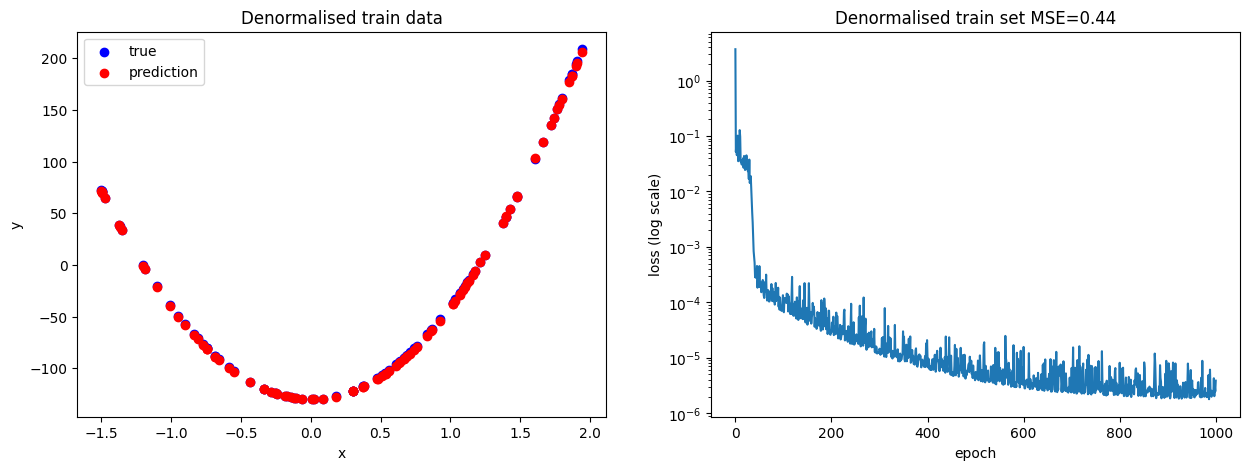

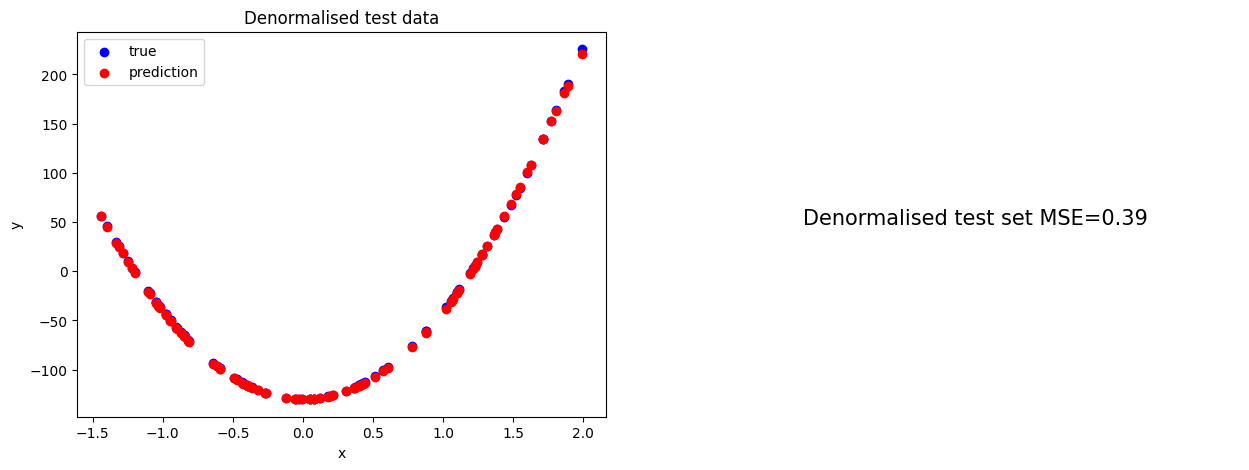

In [141]:
model = MLP([1, 5, 1], 'sigmoid', out_act_fun_name='linear')
losses_sgd, weights_over_epochs, biases_over_epochs = train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, method = 'sgd', first_lr = 0.5, lr_decay_rate = 0, epochs = 1000, n_epochs_displayed = 100)

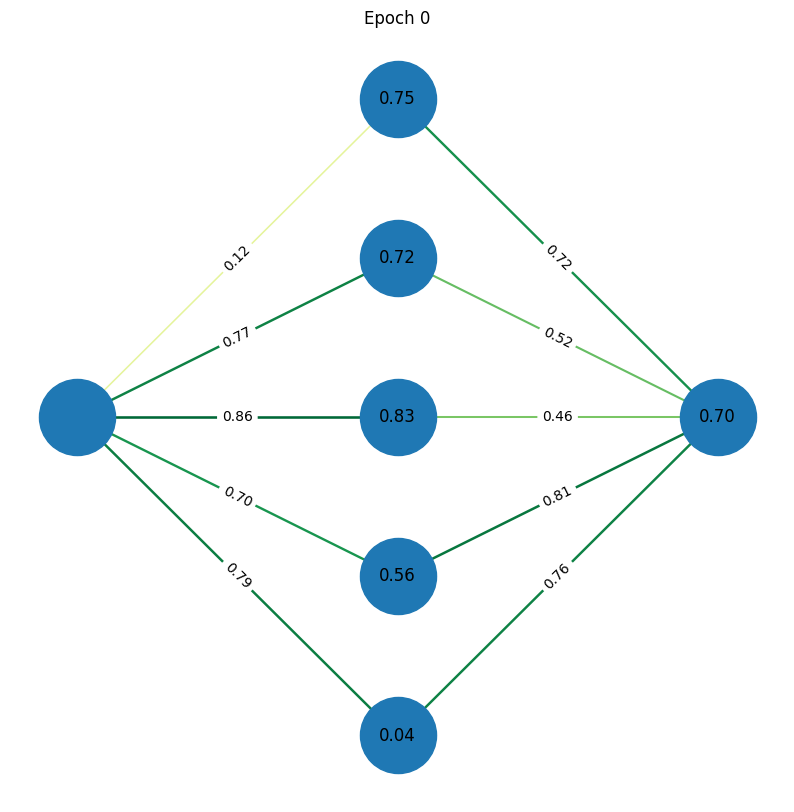

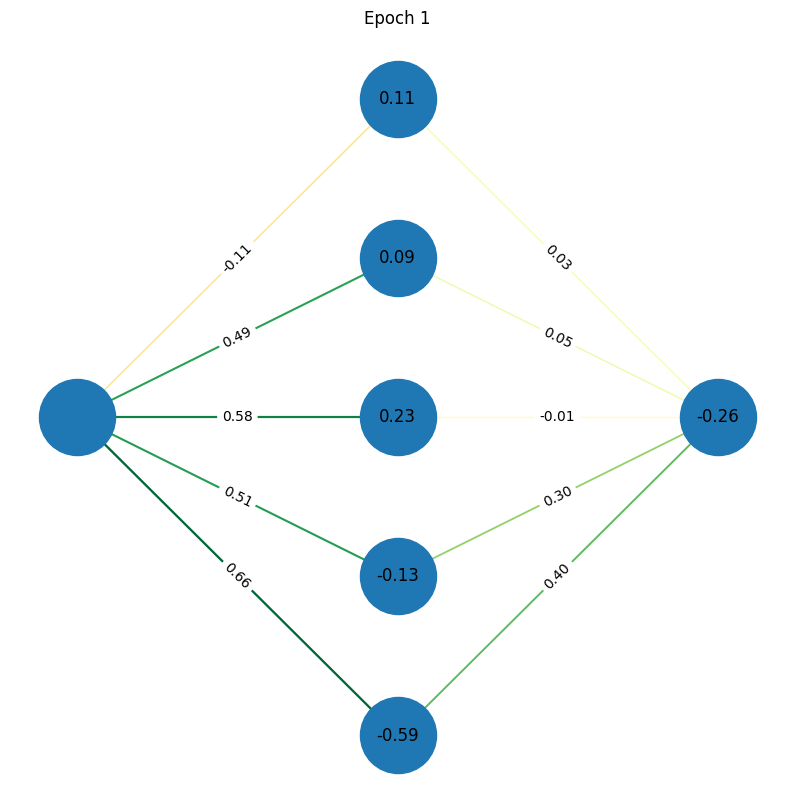

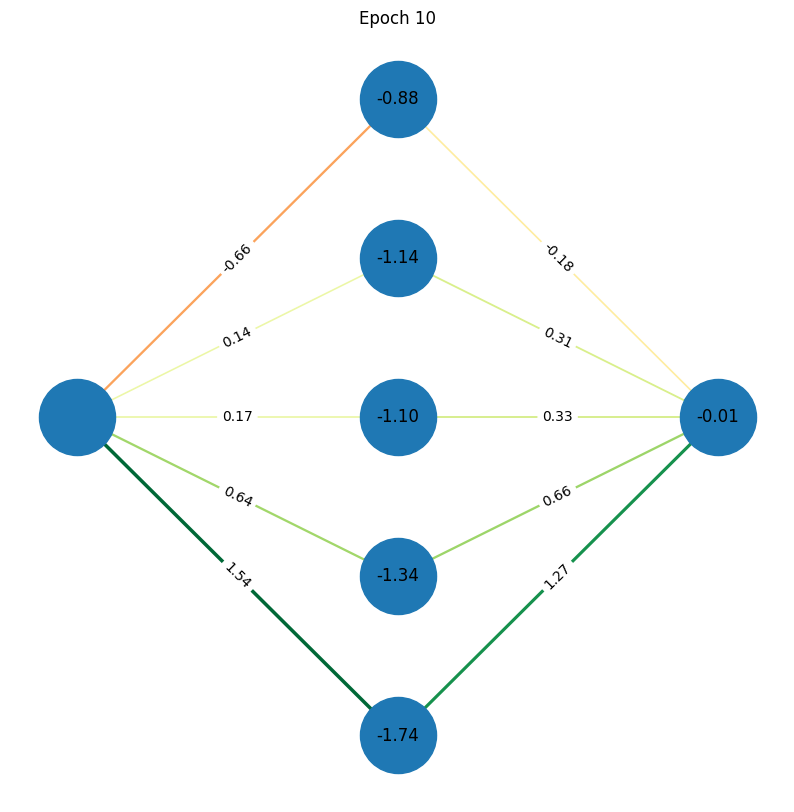

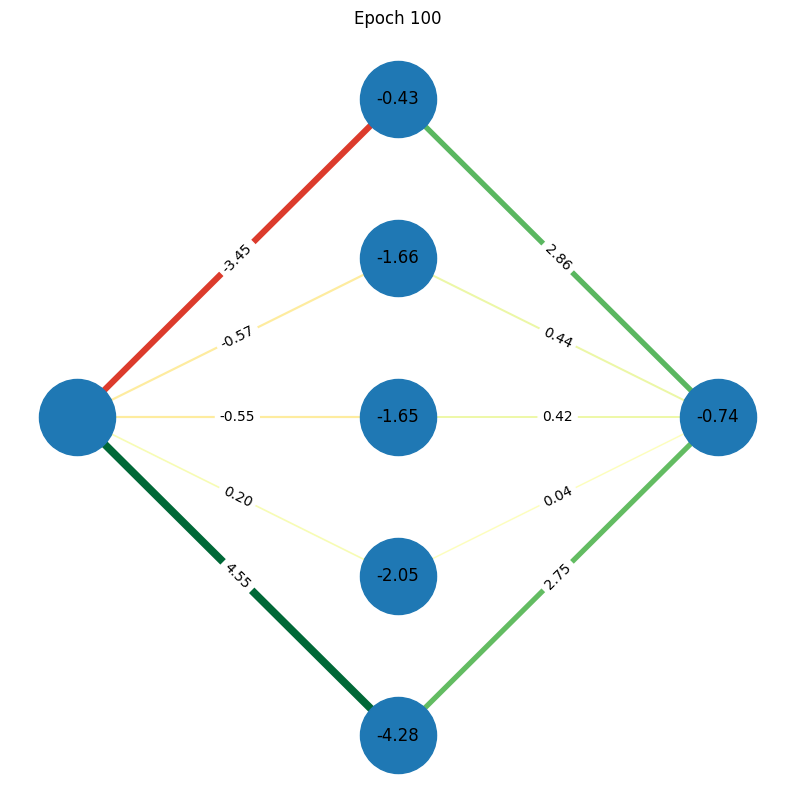

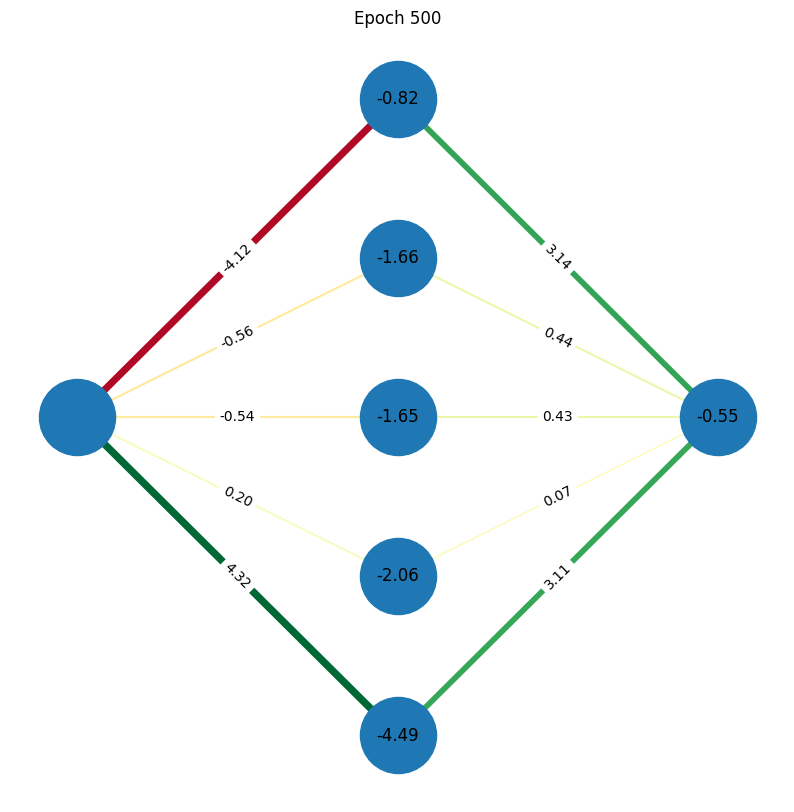

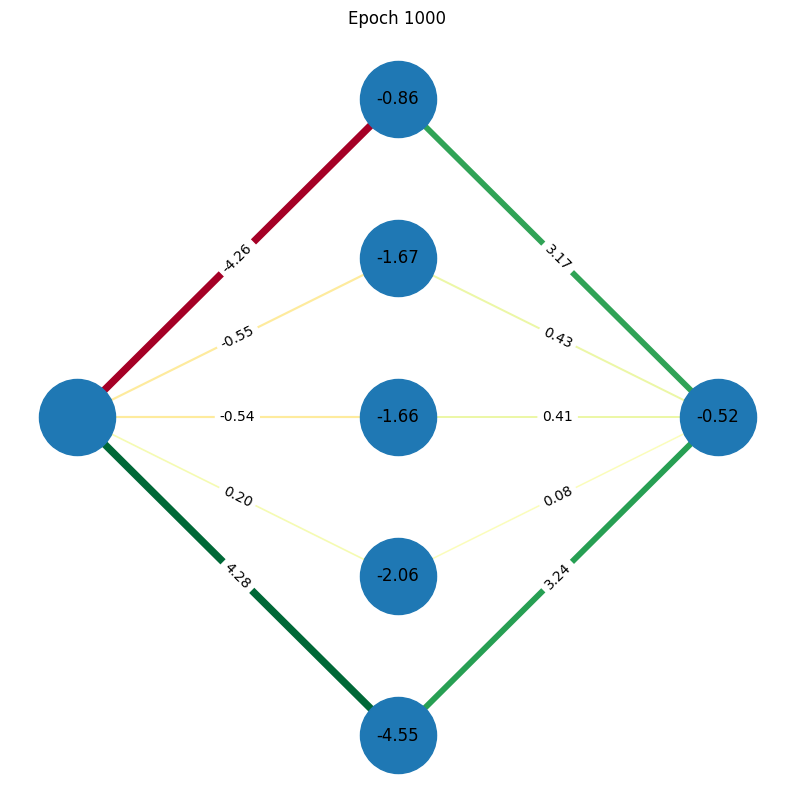

In [142]:
draw_networks_for_epochs(weights_over_epochs, biases_over_epochs, [0, 1, 10, 100, 500, 1000])

## Mini-batch

In [143]:
X_train.shape

(100,)

Epoch 1: loss_fun=0.0406538231046616
Epoch 100: loss_fun=0.055210853115132394
Epoch 200: loss_fun=0.03944834288309257
Epoch 300: loss_fun=0.030655992362821752
Epoch 400: loss_fun=0.026979545801228452
Epoch 500: loss_fun=0.018568924018466385
Epoch 600: loss_fun=0.0022151165866209537
Epoch 700: loss_fun=0.0002556921873152011
Epoch 800: loss_fun=0.00019156614538621883
Epoch 900: loss_fun=0.0001709698109199885
Epoch 1000: loss_fun=0.0001475413219694785


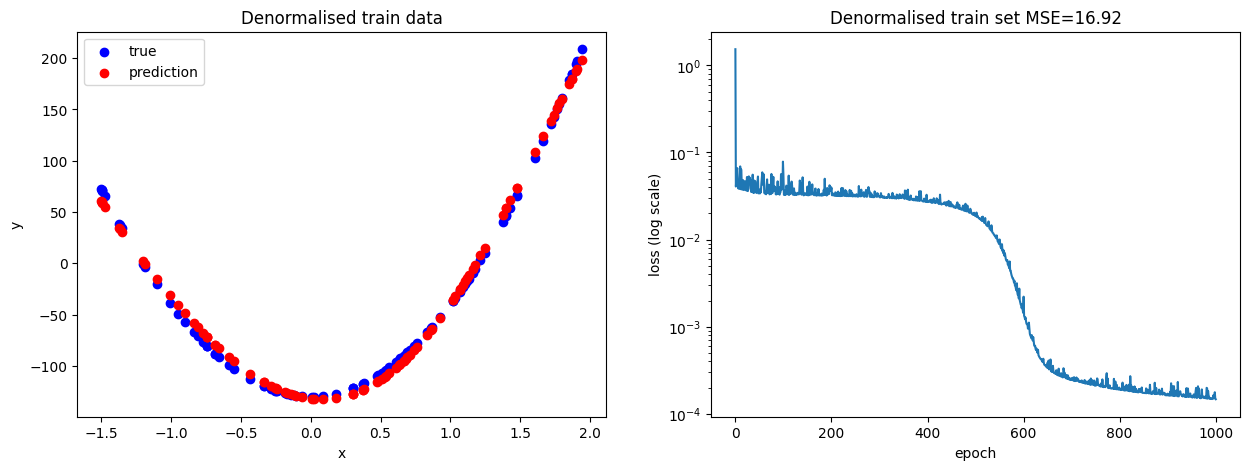

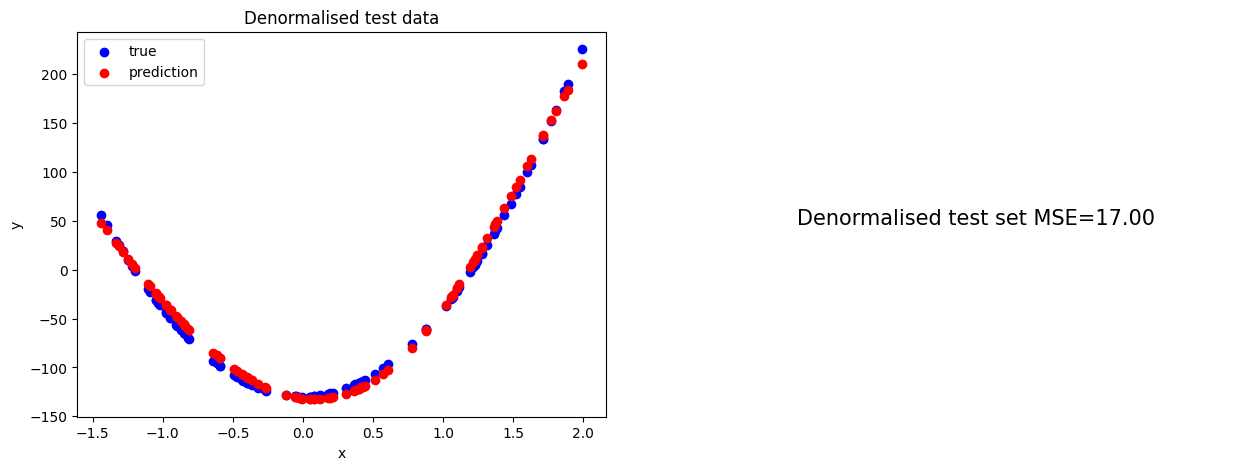

In [144]:
model = MLP([1, 5, 1], 'sigmoid', out_act_fun_name='linear')
losses_mini, _, __ = train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, method = 'minibatch', first_lr = 0.5, lr_decay_rate = 0, epochs = 1000, n_epochs_displayed = 100, batch_size = 10)

## Batch

Epoch 1: loss_fun=2.2087971834440214
Epoch 100: loss_fun=0.03802623101529467
Epoch 200: loss_fun=0.03697191359045551
Epoch 300: loss_fun=0.035941073002500434
Epoch 400: loss_fun=0.03500970147709683
Epoch 500: loss_fun=0.03427522991030836
Epoch 600: loss_fun=0.03377205856008806
Epoch 700: loss_fun=0.03345803447229858
Epoch 800: loss_fun=0.03326206708179936
Epoch 900: loss_fun=0.03312716797340045
Epoch 1000: loss_fun=0.03302089452179719


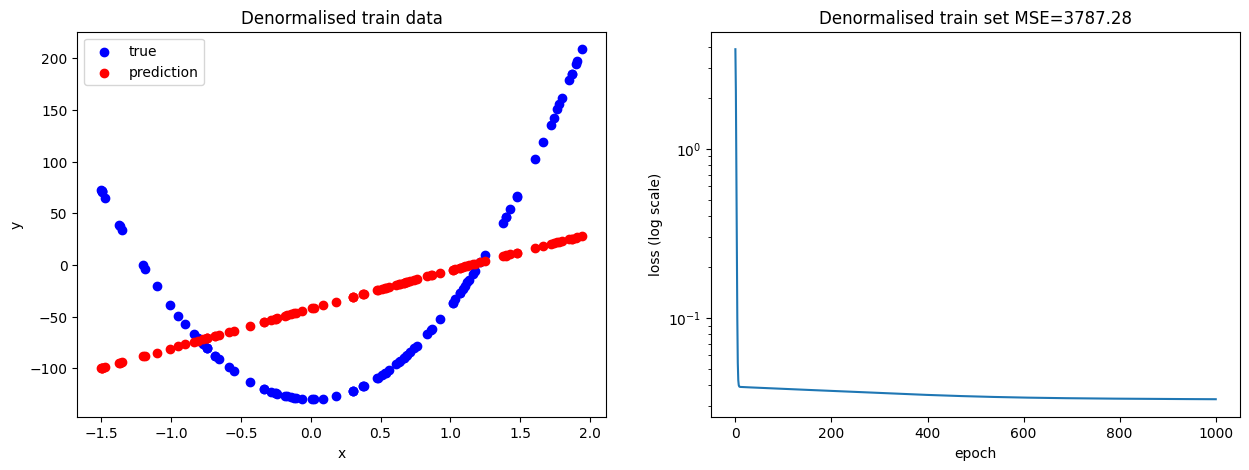

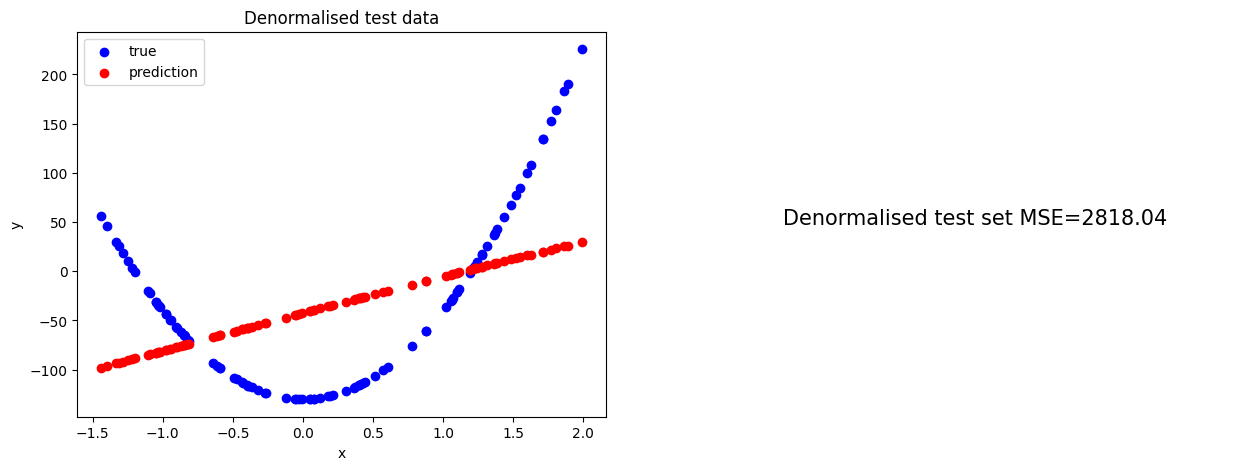

In [145]:
model = MLP([1, 5, 1], 'sigmoid', out_act_fun_name='linear')
losses_batch, _, __  = train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, method = 'batch', first_lr = 0.5, lr_decay_rate = 0, epochs = 1000, n_epochs_displayed = 100)

Podsumowując, z tymi samymi hiperparametrami, szybkość zbieżności to $SGD < MiniBatch(batch\_size=10\%) < Batch$.

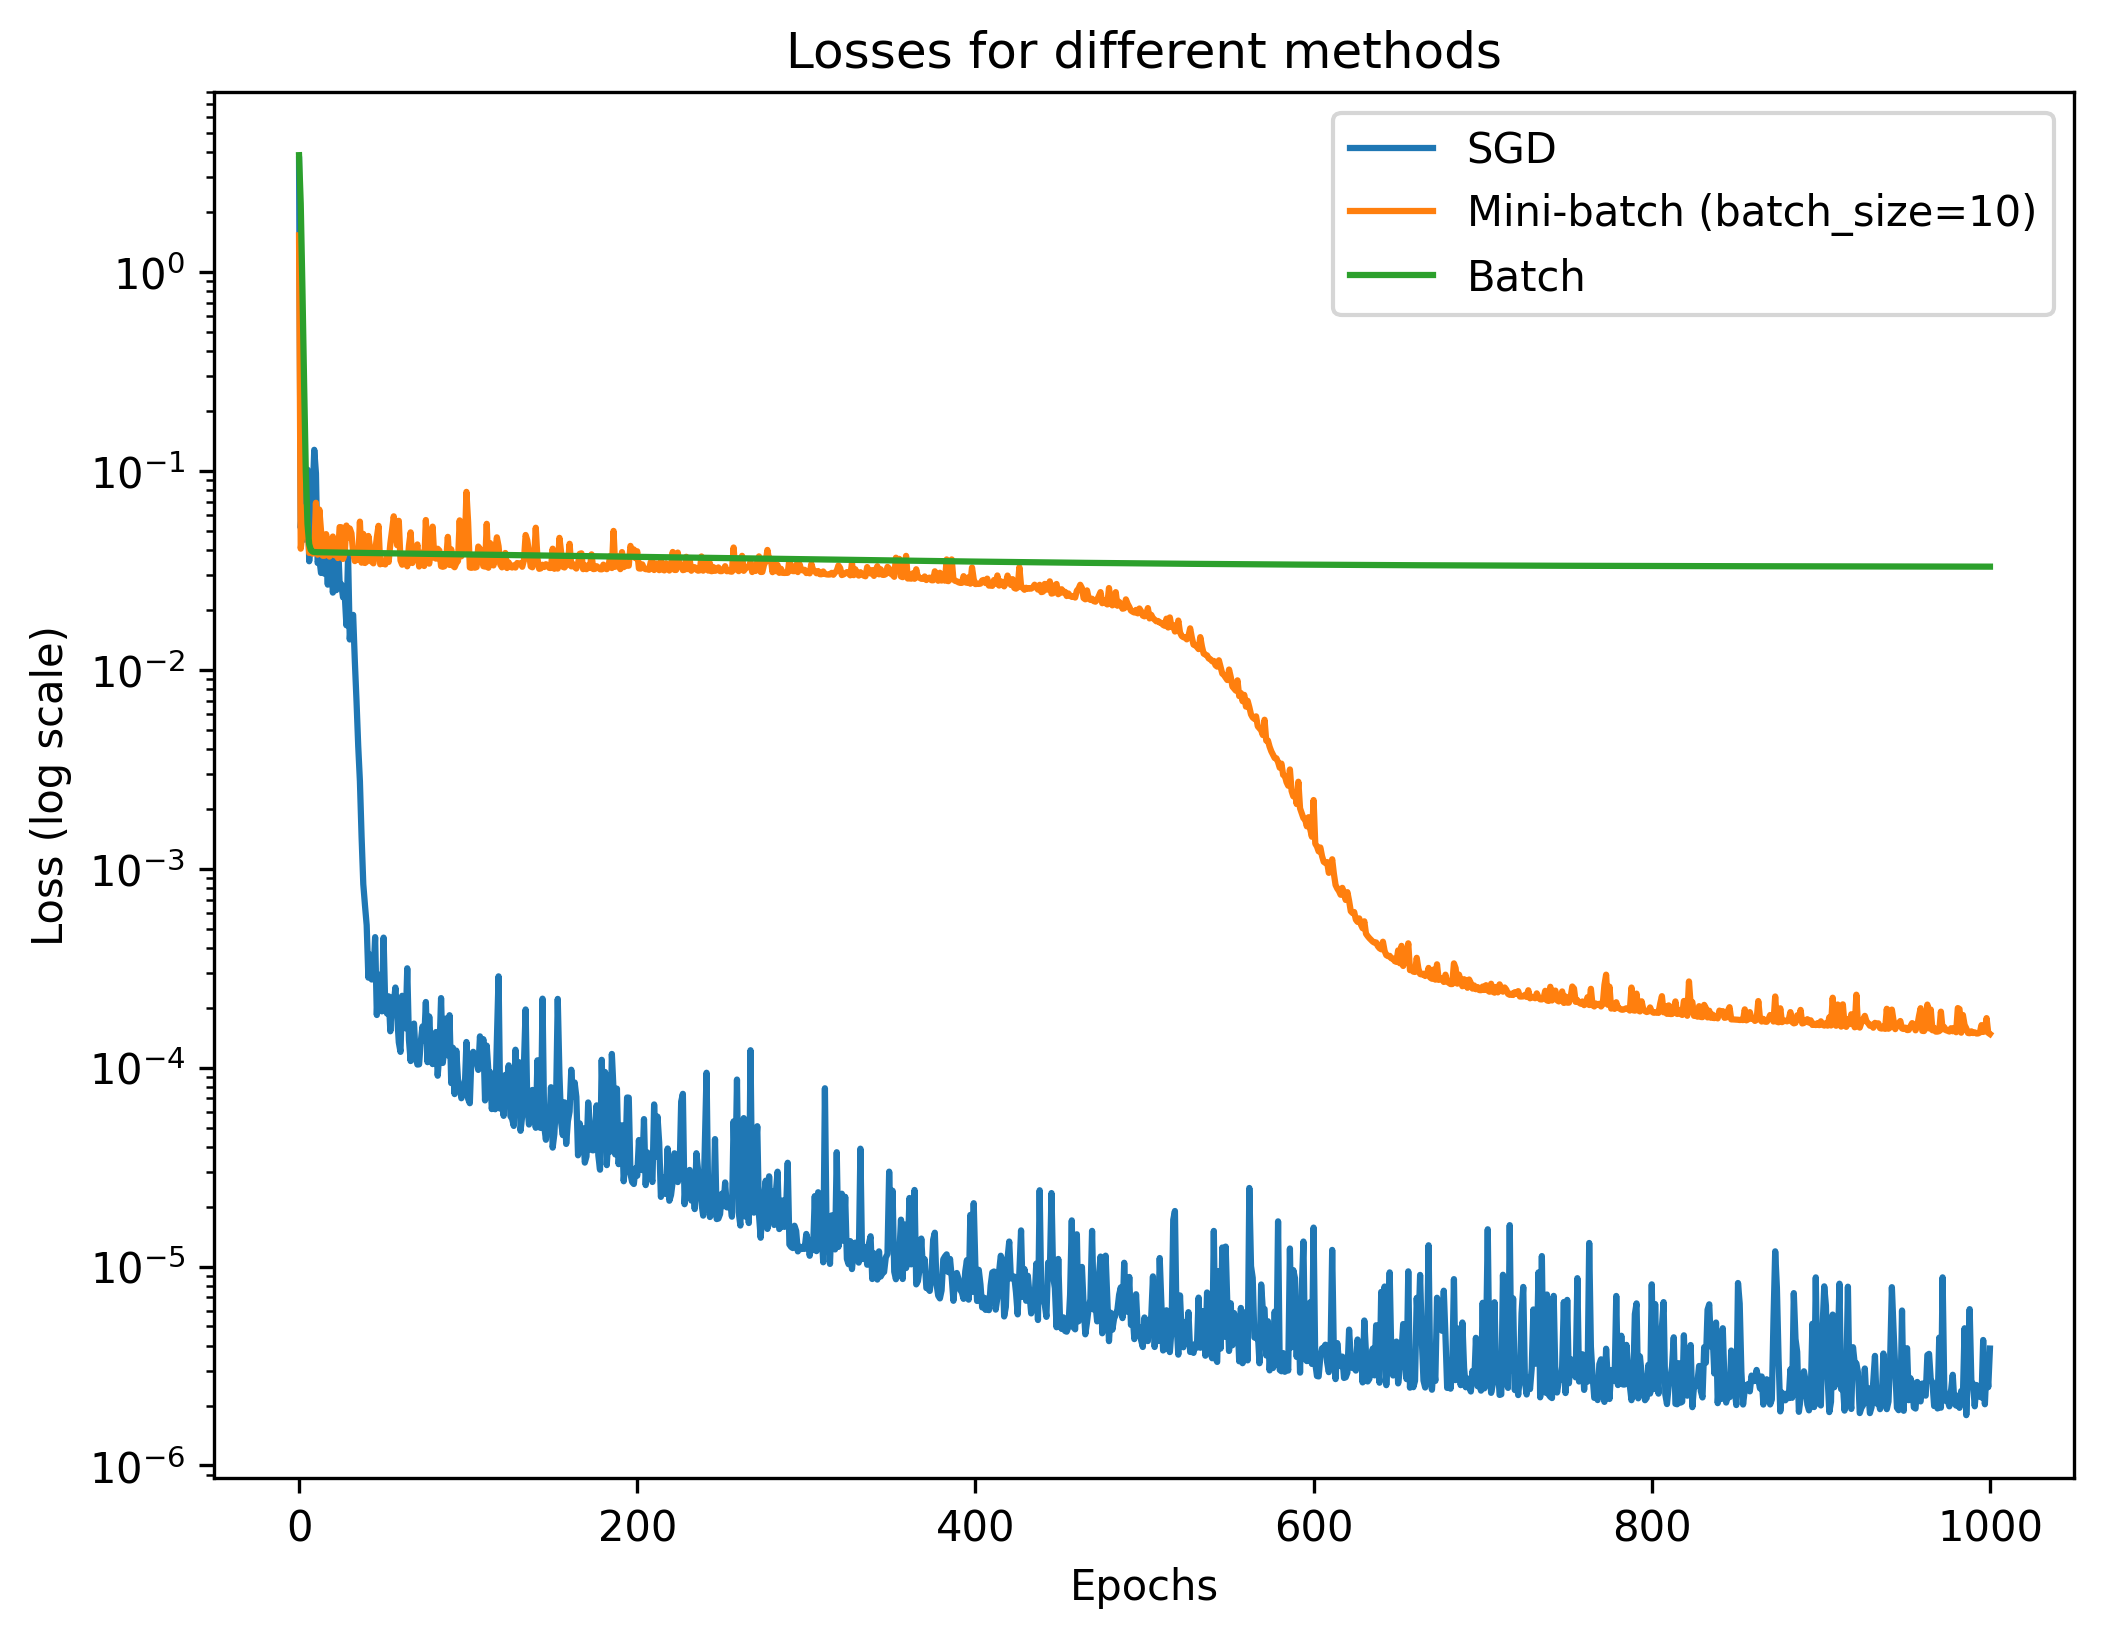

In [146]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

ax.plot(range(len(losses_sgd)), losses_sgd, label='SGD')
ax.plot(range(len(losses_mini)), losses_mini, label='Mini-batch (batch_size=10)')
ax.plot(range(len(losses_batch)), losses_batch, label='Batch')
ax.set_xlabel('Epochs')
ax.set_yscale('log')
ax.set_ylabel('Loss (log scale)')
ax.set_title('Losses for different methods')
ax.legend()
plt.show()

# Steps-small

In [158]:
X_train = pd.read_csv('data/regression/steps-small-training.csv')['x']
Y_train = pd.read_csv('data/regression/steps-small-training.csv')['y']
X_test = pd.read_csv('data/regression/steps-small-test.csv')['x']
Y_test = pd.read_csv('data/regression/steps-small-test.csv')['y']

## SGD

Epoch 1: loss_fun=0.060625236163700046
Epoch 1000: loss_fun=0.01226200521271616
Epoch 2000: loss_fun=0.0074268294389218835
Epoch 3000: loss_fun=0.0034026379190595204
Epoch 4000: loss_fun=0.0033460742589601356
Epoch 5000: loss_fun=0.00624905509596755
Epoch 6000: loss_fun=0.01101383788910809
Epoch 7000: loss_fun=0.00775742189638871
Epoch 8000: loss_fun=0.011124328233360396
Epoch 9000: loss_fun=0.006883646024075468
Epoch 10000: loss_fun=0.0029017199212036156
Epoch 11000: loss_fun=0.007536606715505643
Epoch 12000: loss_fun=0.008566336937402308
Epoch 13000: loss_fun=0.0028733698079115534
Epoch 14000: loss_fun=0.002614566801828568
Epoch 15000: loss_fun=0.01305978124092523
Epoch 16000: loss_fun=0.0029234087835202883
Epoch 17000: loss_fun=0.0027200076221563442
Epoch 18000: loss_fun=0.0026660742876246017
Epoch 19000: loss_fun=0.0023302353795075182
Epoch 20000: loss_fun=0.0022328594425670627
Epoch 21000: loss_fun=0.012022992042526302
Epoch 22000: loss_fun=0.006697704367042418
Epoch 23000: loss_f

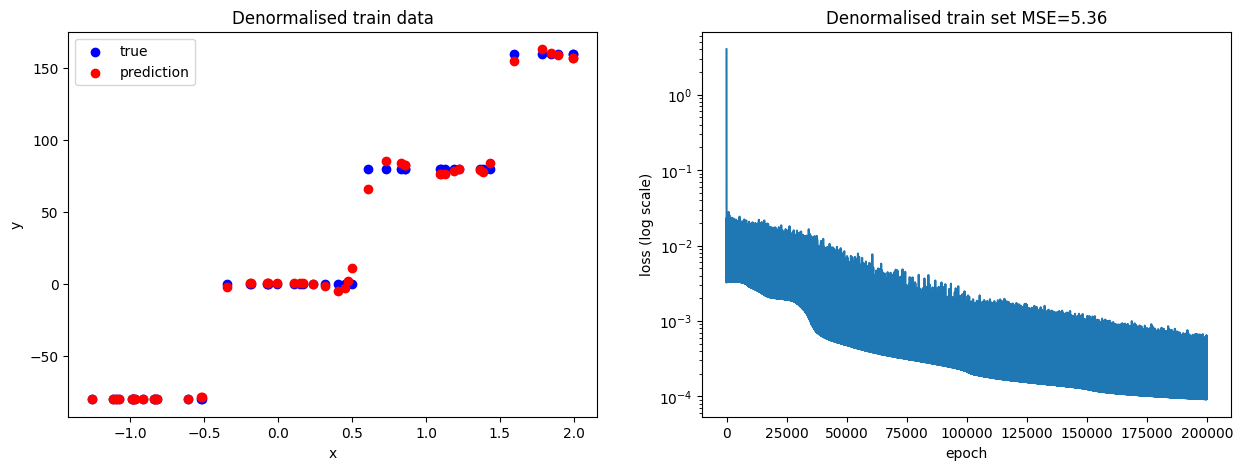

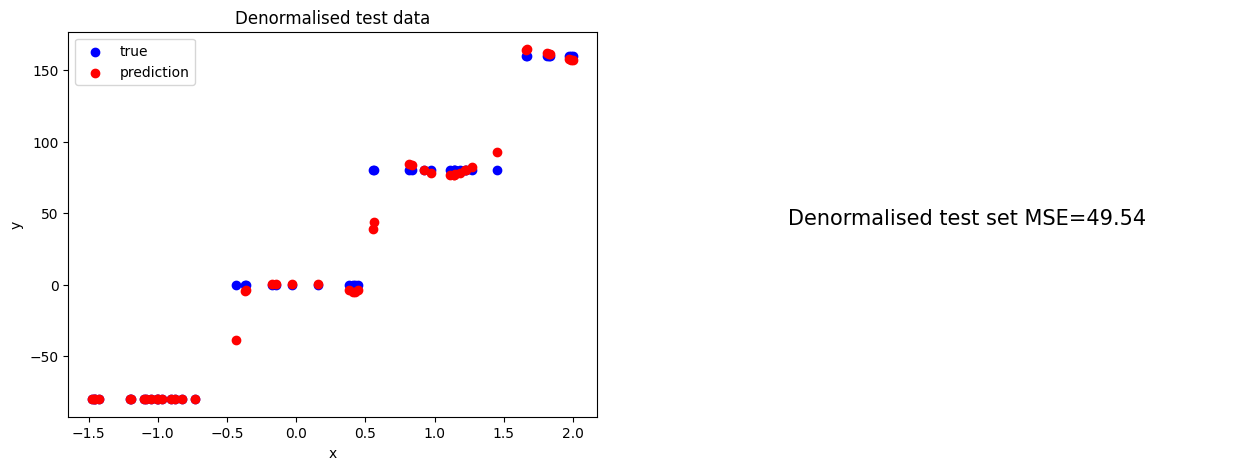

In [159]:
model = MLP([1, 5, 5, 1], 'sigmoid', out_act_fun_name='linear')
losses_sgd, weights_over_epochs, biases_over_epochs = train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, method = 'sgd', first_lr = 0.9, lr_decay_rate = 1e-5, epochs = 200000, n_epochs_displayed = 1000)

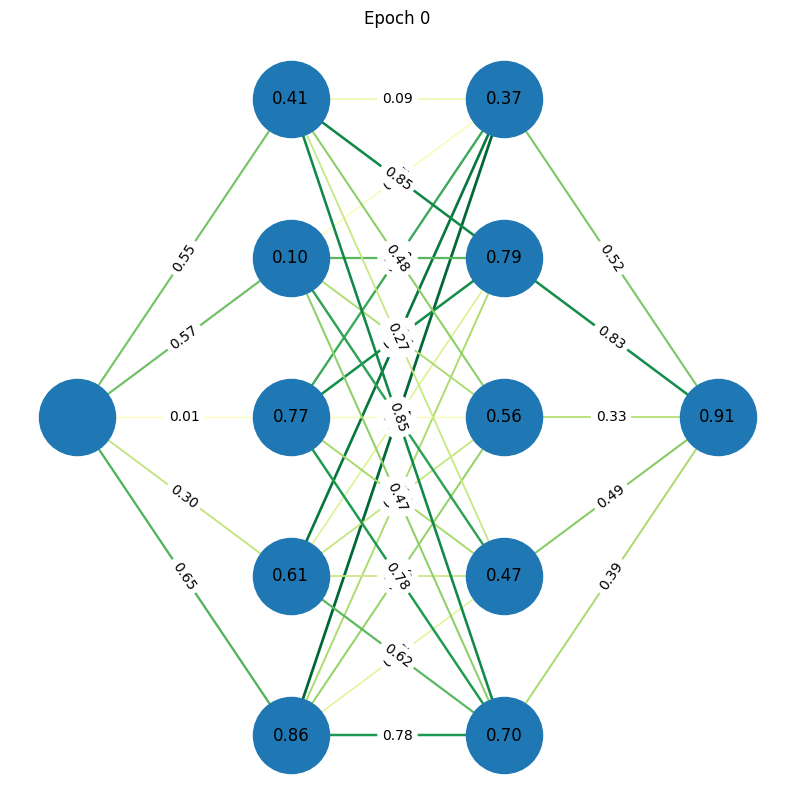

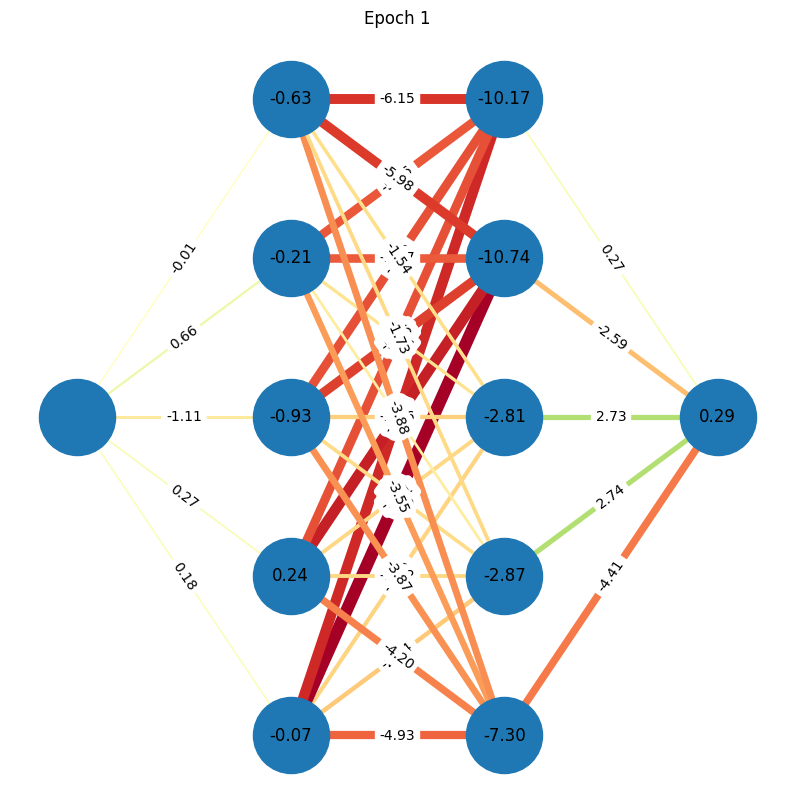

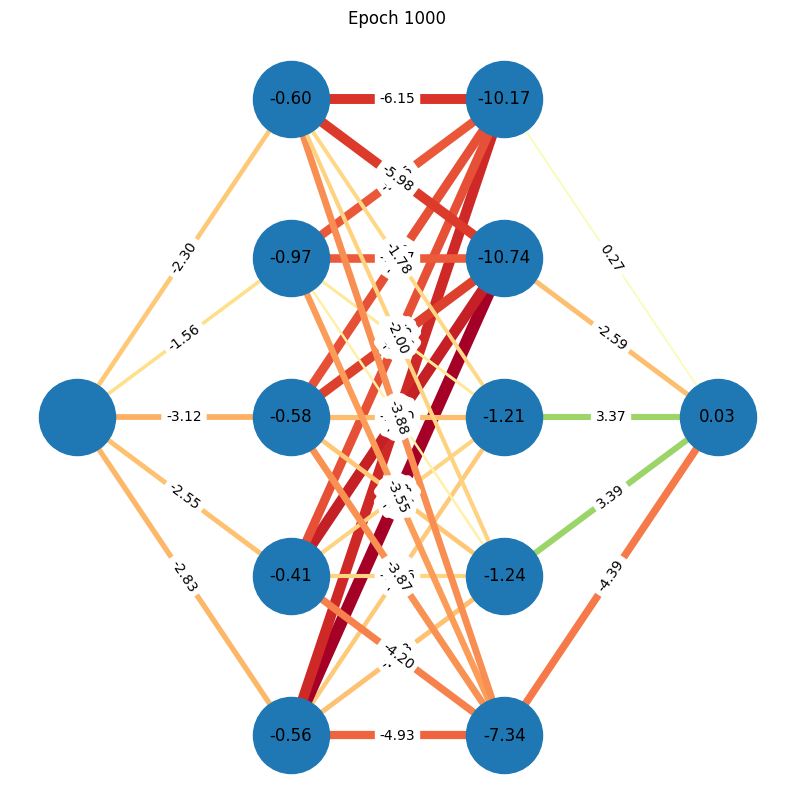

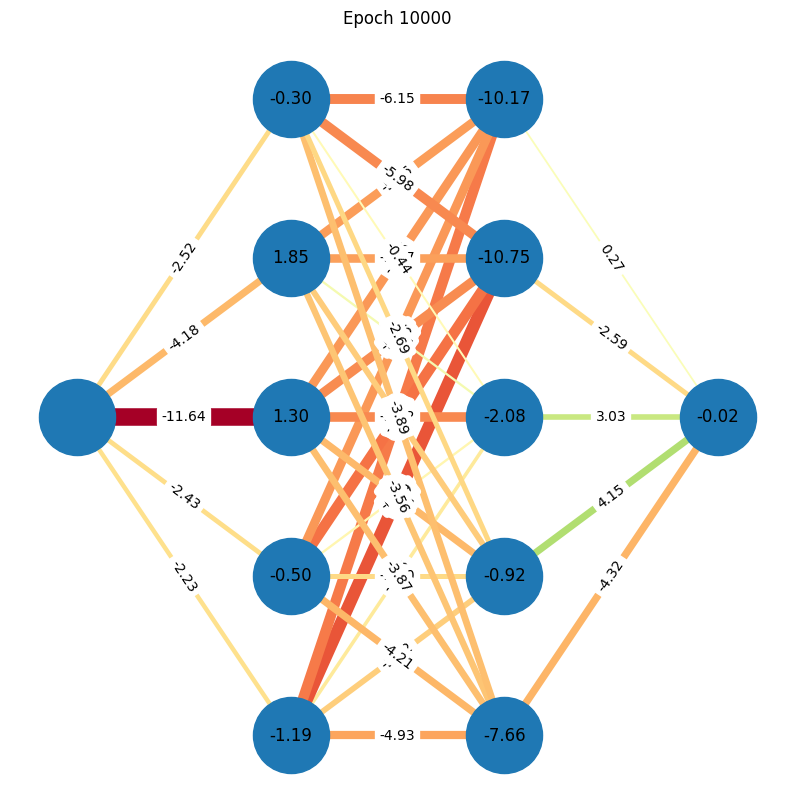

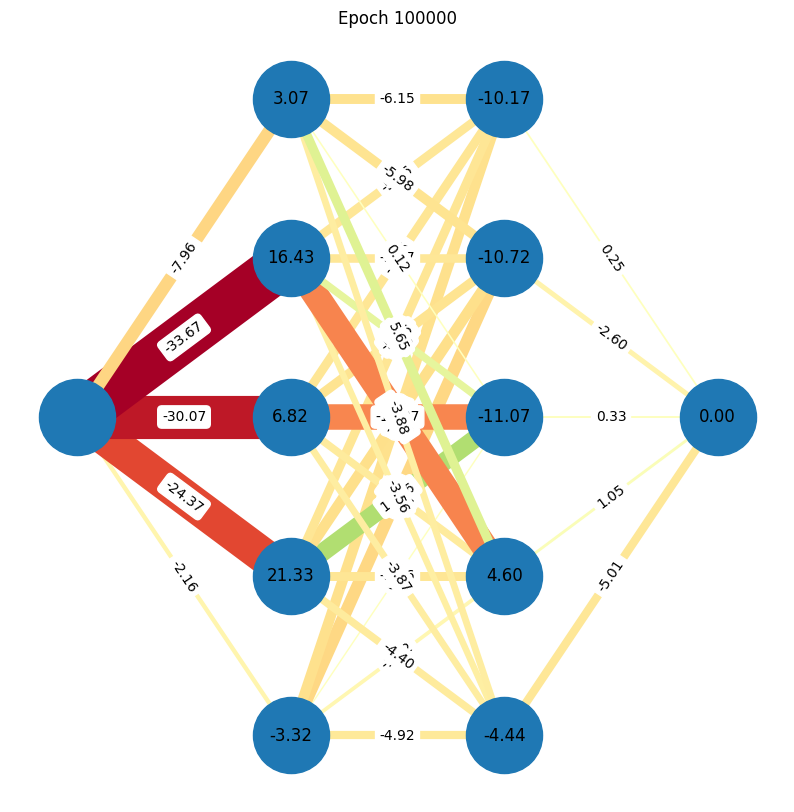

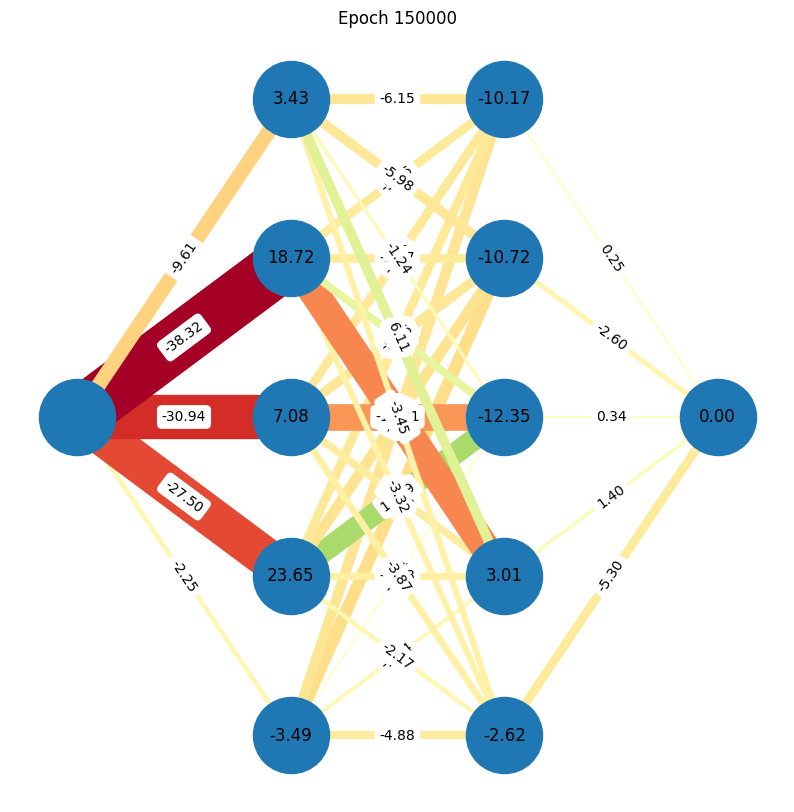

In [160]:
draw_networks_for_epochs(weights_over_epochs, biases_over_epochs, [0, 1, 1000, 10000, 100000, 150000])

## Mini-batch

Epoch 1: loss_fun=0.06342896138284825
Epoch 1000: loss_fun=0.05818799696671571
Epoch 2000: loss_fun=0.07322386892172231
Epoch 3000: loss_fun=0.05558098223839489
Epoch 4000: loss_fun=0.05808212187150639
Epoch 5000: loss_fun=0.07569838168647193
Epoch 6000: loss_fun=0.07683003589822959
Epoch 7000: loss_fun=0.056611131686680374
Epoch 8000: loss_fun=0.06411933742550618
Epoch 9000: loss_fun=0.055597028140396985
Epoch 10000: loss_fun=0.05557314295450943
Epoch 11000: loss_fun=0.060856288594108715
Epoch 12000: loss_fun=0.06437098500163954
Epoch 13000: loss_fun=0.06241777525813652
Epoch 14000: loss_fun=0.06514125617914514
Epoch 15000: loss_fun=0.062592284987722
Epoch 16000: loss_fun=0.07115187953317725
Epoch 17000: loss_fun=0.07198906918921573
Epoch 18000: loss_fun=0.05686083259393712
Epoch 19000: loss_fun=0.05555577733884532
Epoch 20000: loss_fun=0.06006128481827194
Epoch 21000: loss_fun=0.05748184083004066
Epoch 22000: loss_fun=0.06756565382930733
Epoch 23000: loss_fun=0.07054871821749409
Epoc

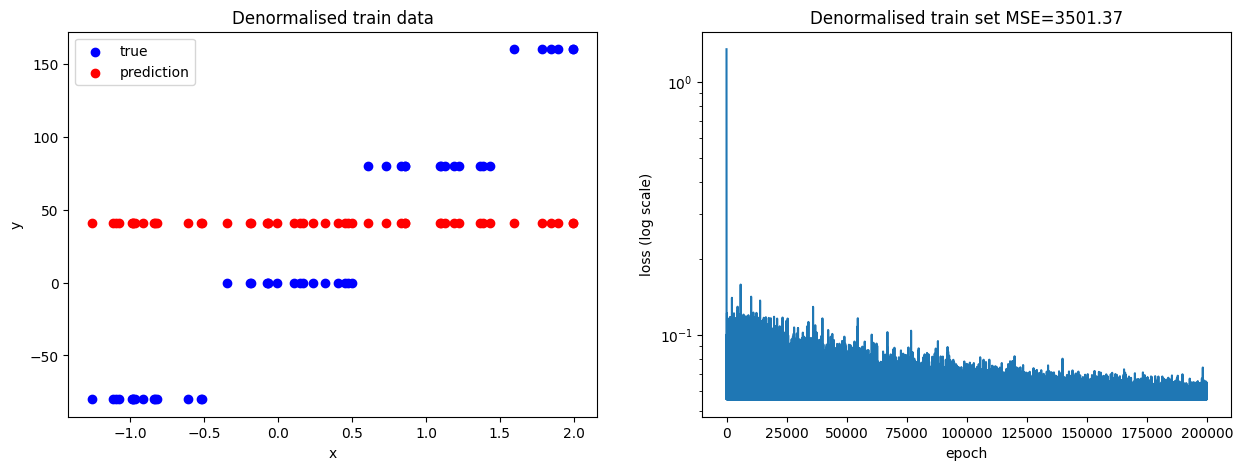

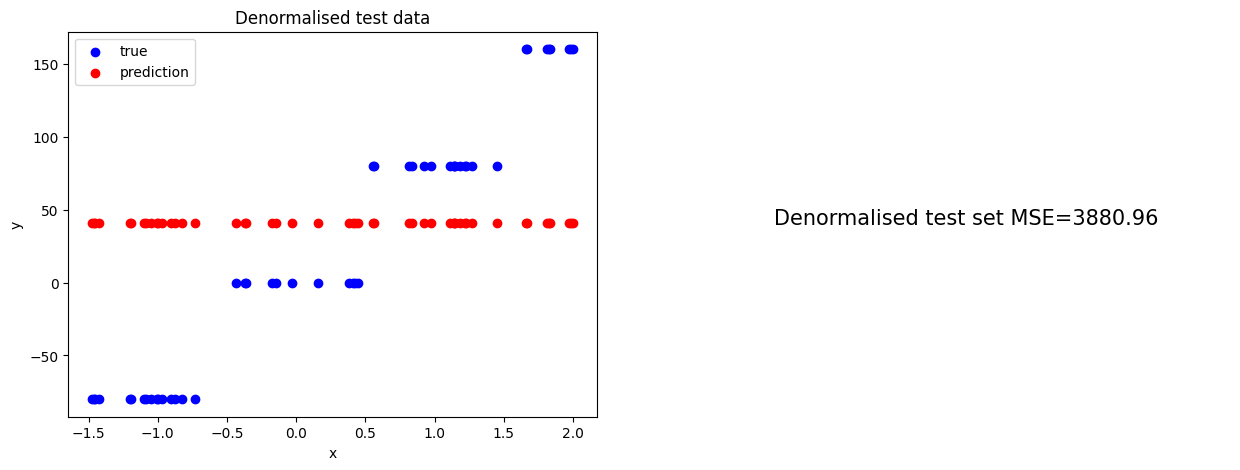

In [161]:
model = MLP([1, 5, 5, 1], 'sigmoid', out_act_fun_name='linear')
losses_mini, weights_over_epochs, biases_over_epochs = train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, method = 'mini', first_lr = 0.9, lr_decay_rate = 1e-5, epochs = 200000, n_epochs_displayed = 1000, batch_size = 5)

## Batch

Epoch 1: loss_fun=7.533714524786885
Epoch 1000: loss_fun=0.036663885890932196
Epoch 2000: loss_fun=0.005737215986769623
Epoch 3000: loss_fun=0.004819046148504784
Epoch 4000: loss_fun=0.00413798867771981
Epoch 5000: loss_fun=0.003737860281340324
Epoch 6000: loss_fun=0.0034990192137552057
Epoch 7000: loss_fun=0.0033556855496145906
Epoch 8000: loss_fun=0.003268621475047315
Epoch 9000: loss_fun=0.0032147634876550867
Epoch 10000: loss_fun=0.00318070319468473
Epoch 11000: loss_fun=0.0031589750746088933
Epoch 12000: loss_fun=0.0031464773026587756
Epoch 13000: loss_fun=0.003142175539008304
Epoch 14000: loss_fun=0.0031408782612811293
Epoch 15000: loss_fun=0.0031397752617803843
Epoch 16000: loss_fun=0.003138752150194029
Epoch 17000: loss_fun=0.003137800772244697
Epoch 18000: loss_fun=0.0031369141644803657
Epoch 19000: loss_fun=0.0031360862151220553
Epoch 20000: loss_fun=0.0031353115307262438
Epoch 21000: loss_fun=0.0031345853370236907
Epoch 22000: loss_fun=0.0031339033957898804
Epoch 23000: loss

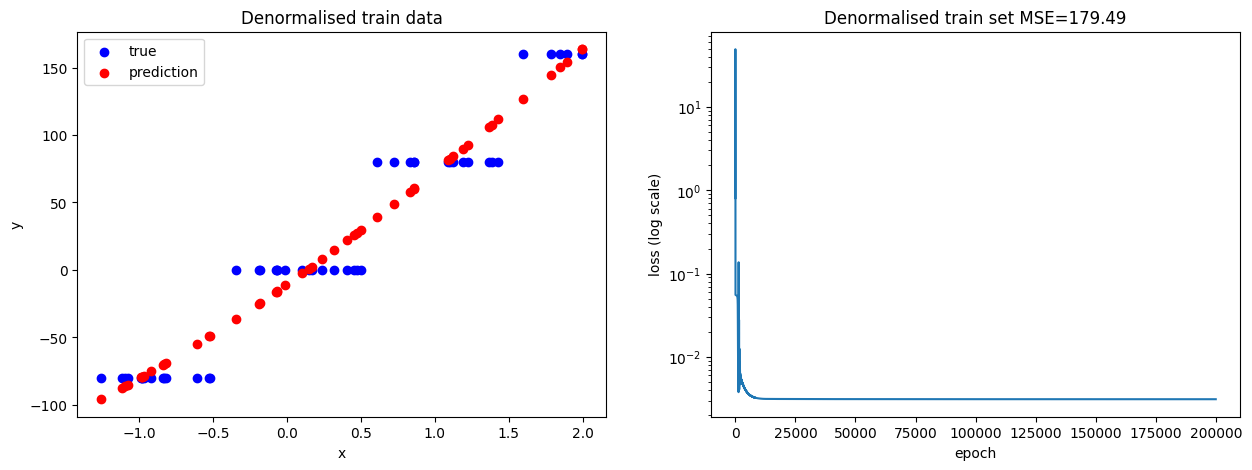

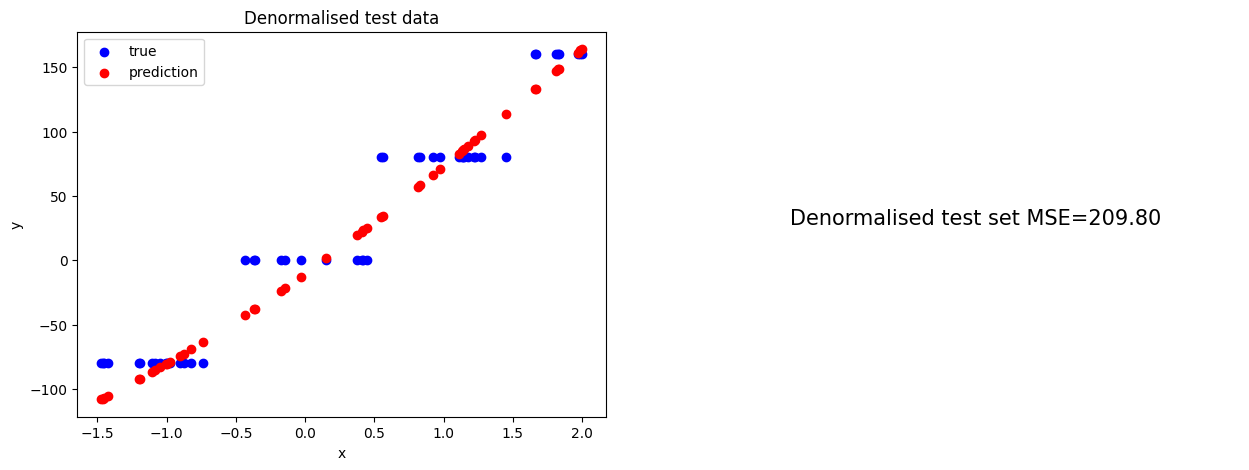

In [162]:
model = MLP([1, 5, 5, 1], 'sigmoid', out_act_fun_name='linear')
losses_batch, weights_over_epochs, biases_over_epochs = train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, method = 'batch', first_lr = 0.9, lr_decay_rate = 1e-5, epochs = 200000, n_epochs_displayed = 1000)

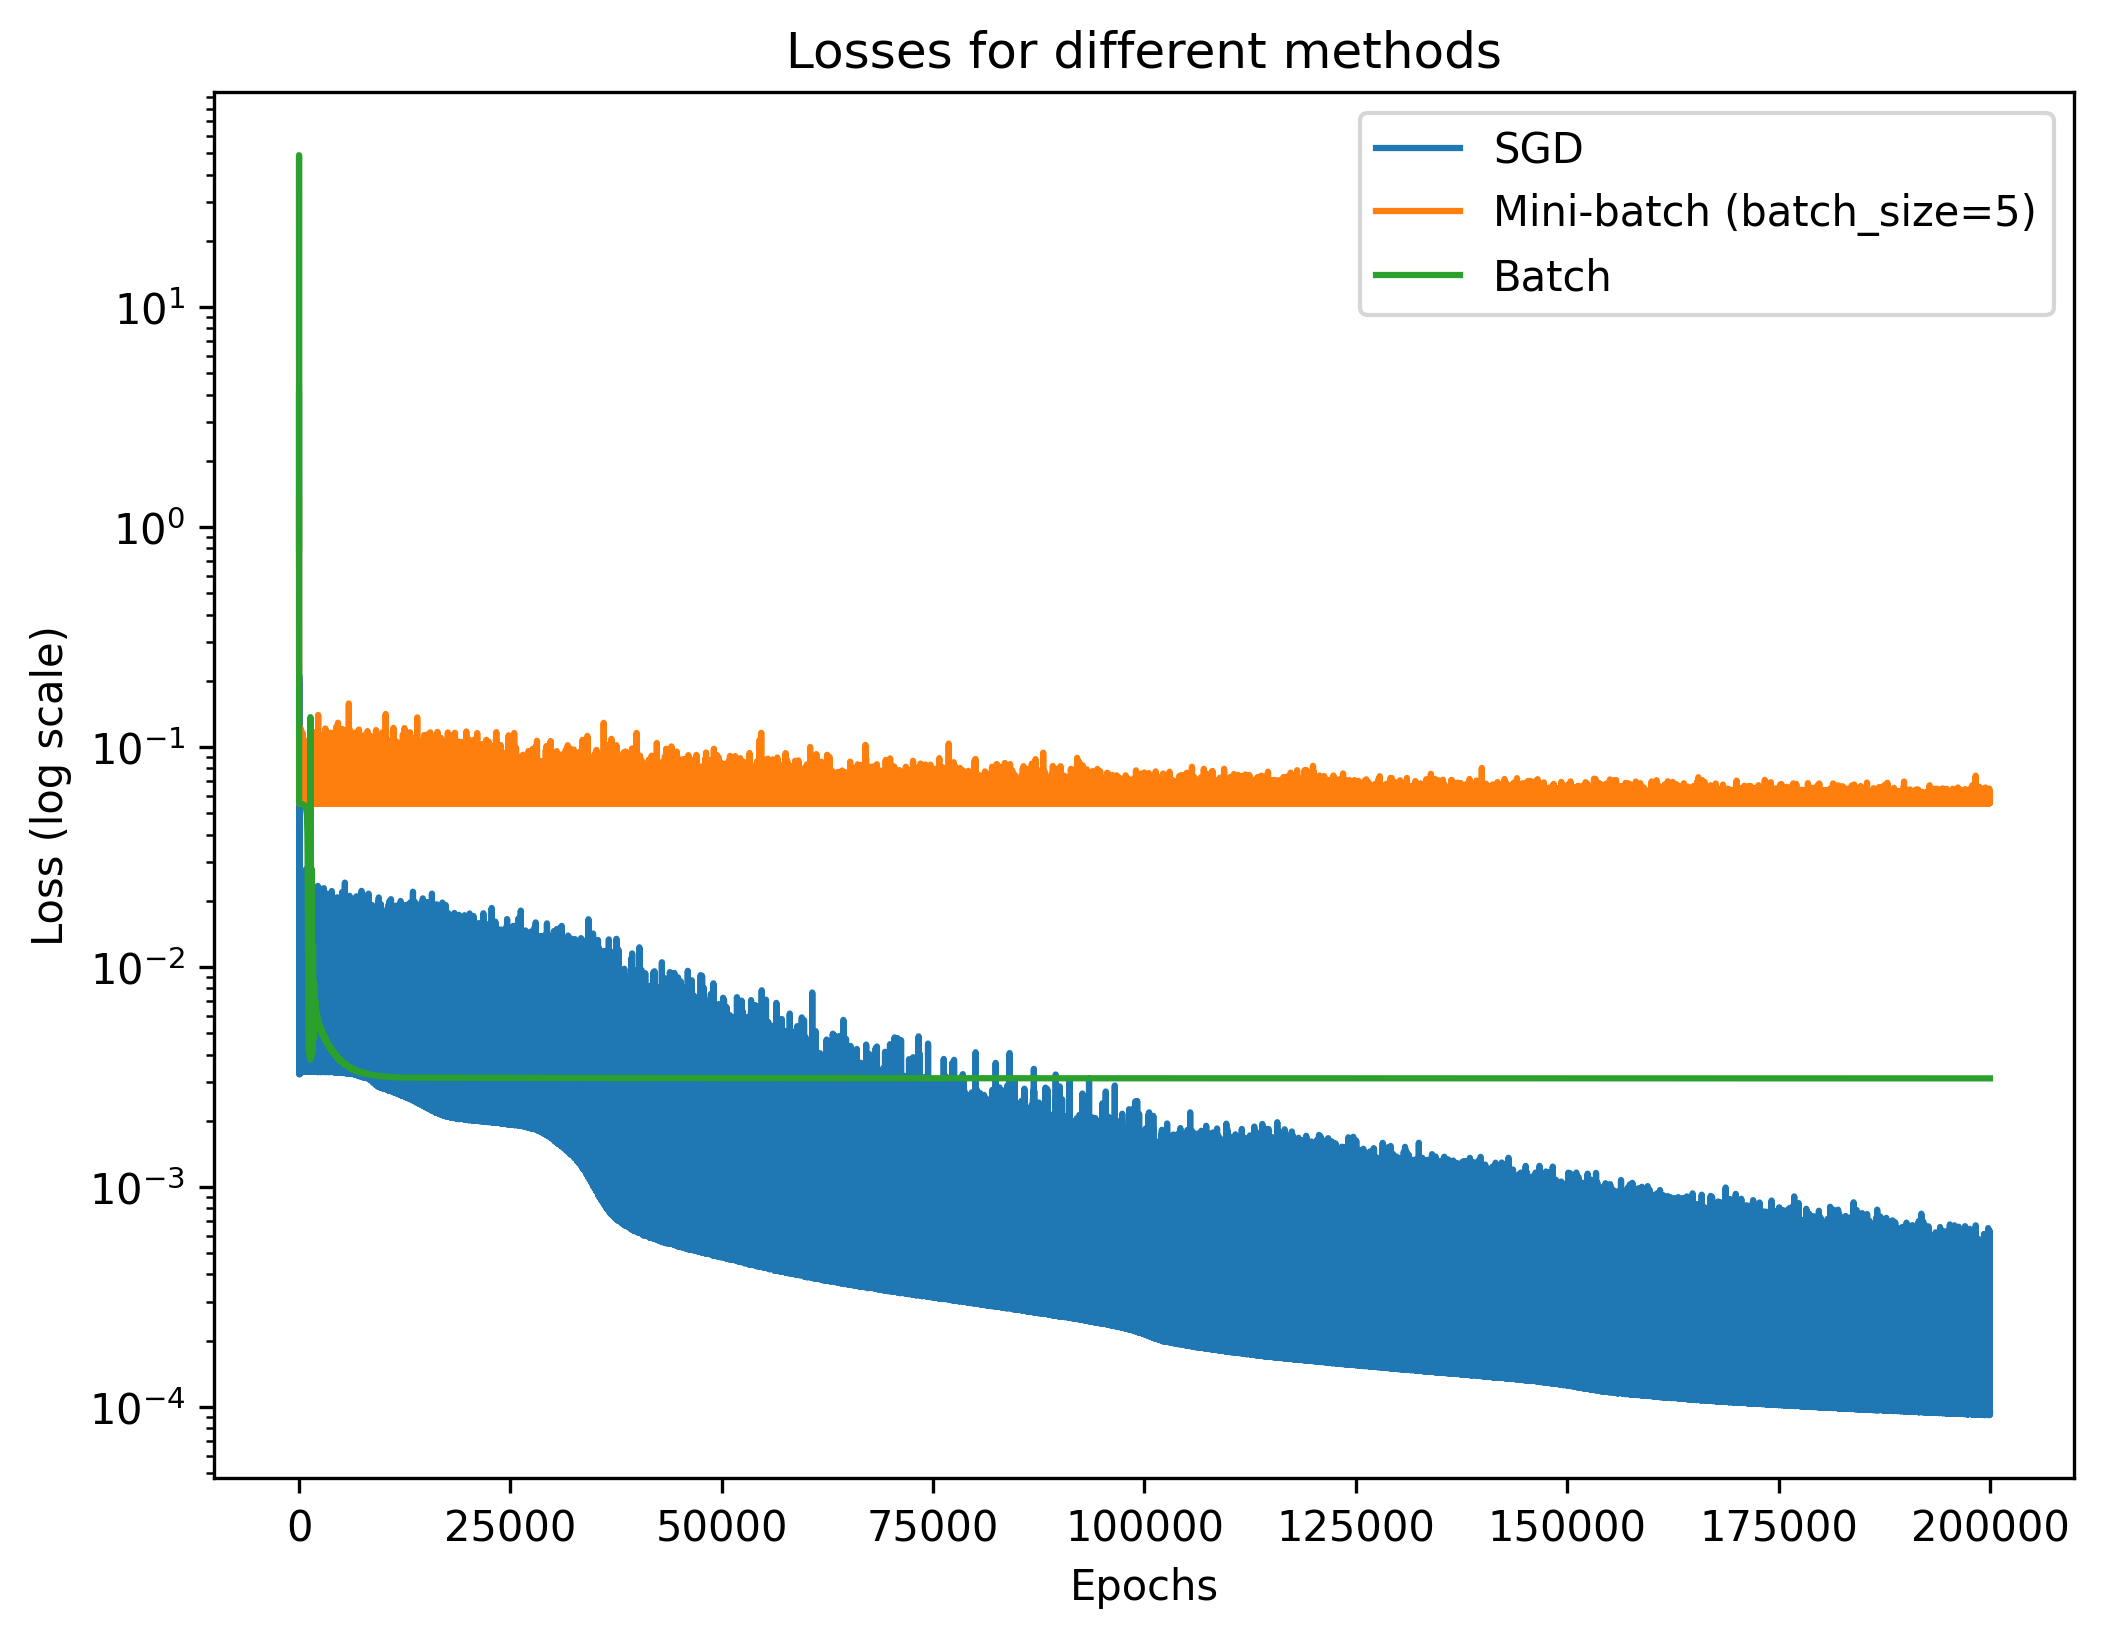

In [163]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

ax.plot(range(len(losses_sgd)), losses_sgd, label='SGD')
ax.plot(range(len(losses_mini)), losses_mini, label='Mini-batch (batch_size=5)')
ax.plot(range(len(losses_batch)), losses_batch, label='Batch')
ax.set_xlabel('Epochs')
ax.set_yscale('log')
ax.set_ylabel('Loss (log scale)')
ax.set_title('Losses for different methods')
ax.legend()
plt.show()

# Multimodal-large

In [153]:
X_train = pd.read_csv('data/regression/multimodal-large-training.csv')['x']
Y_train = pd.read_csv('data/regression/multimodal-large-training.csv')['y']
X_test = pd.read_csv('data/regression/multimodal-large-test.csv')['x']
Y_test = pd.read_csv('data/regression/multimodal-large-test.csv')['y']

## SGD

Epoch 1: loss_fun=0.06192724794704581
Epoch 10: loss_fun=0.026239055025511267
Epoch 20: loss_fun=0.016246579713982613
Epoch 30: loss_fun=0.012167002563474943
Epoch 40: loss_fun=0.007956101528858013
Epoch 50: loss_fun=0.00497404255386404
Epoch 60: loss_fun=0.006297136441718068
Epoch 70: loss_fun=0.004686851044776483
Epoch 80: loss_fun=0.004325996509873435
Epoch 90: loss_fun=0.005922103839599582
Epoch 100: loss_fun=0.004217242407630959
Epoch 110: loss_fun=0.0036749127858469407
Epoch 120: loss_fun=0.0037400808690608947
Epoch 130: loss_fun=0.003756441266005622
Epoch 140: loss_fun=0.003555999978636953
Epoch 150: loss_fun=0.003885443979667852
Epoch 160: loss_fun=0.0034943252731894766
Epoch 170: loss_fun=0.003483865363028019
Epoch 180: loss_fun=0.004706351637676589
Epoch 190: loss_fun=0.003430823038906709
Epoch 200: loss_fun=0.005571700627900059
Epoch 210: loss_fun=0.003124521913774021
Epoch 220: loss_fun=0.003028955833279193
Epoch 230: loss_fun=0.004124955583920628
Epoch 240: loss_fun=0.0035

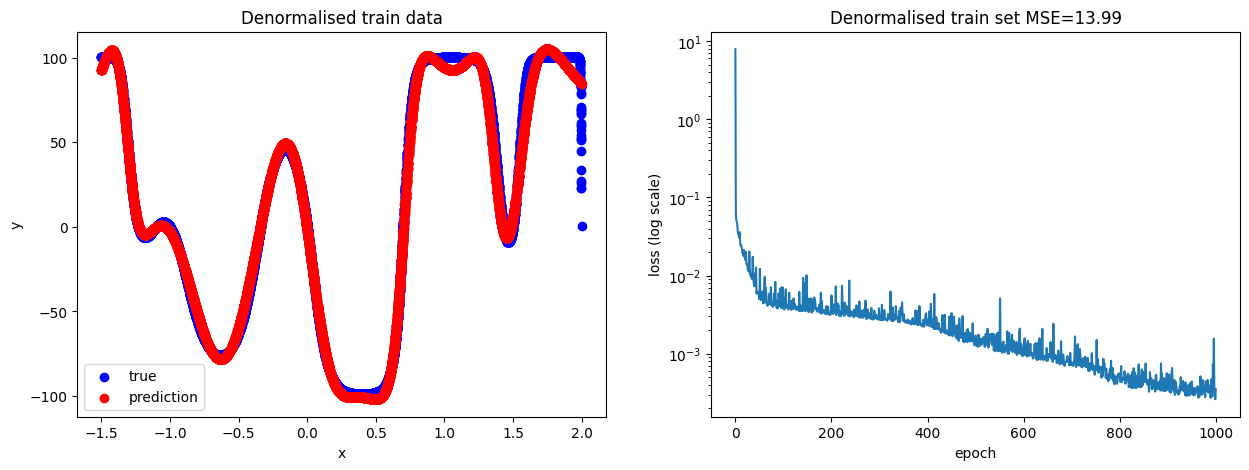

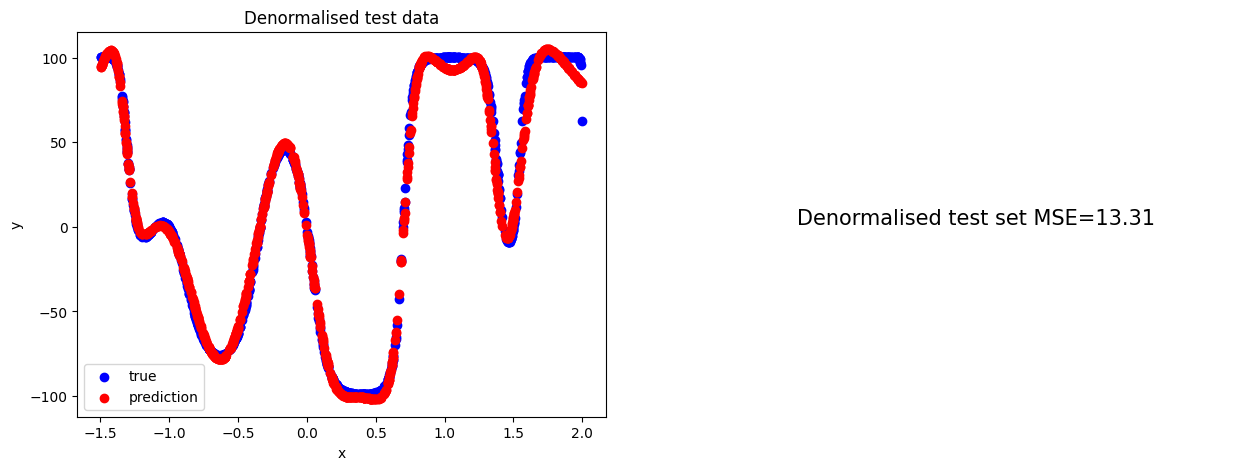

In [154]:
model = MLP([1, 10, 10, 1], 'sigmoid', out_act_fun_name='linear')
losses_sgd, _, __ = train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, method = 'sgd', first_lr = 0.1, lr_decay_rate = 1e-3, epochs = 1000, n_epochs_displayed = 10)

## Mini-batch

Epoch 1: loss_fun=0.0646657383628015
Epoch 2: loss_fun=0.06119325931211877
Epoch 3: loss_fun=0.05855009734123521
Epoch 4: loss_fun=0.056609974221303205
Epoch 5: loss_fun=0.055578999700961904
Epoch 6: loss_fun=0.055124582180669505
Epoch 7: loss_fun=0.05435021824365195
Epoch 8: loss_fun=0.05374398665266916
Epoch 9: loss_fun=0.05354672342680571
Epoch 10: loss_fun=0.05216494404345892
Epoch 11: loss_fun=0.051176278071793924
Epoch 12: loss_fun=0.050288003225225836
Epoch 13: loss_fun=0.04968185729263931
Epoch 14: loss_fun=0.04780265416663793
Epoch 15: loss_fun=0.04539723639447267
Epoch 16: loss_fun=0.04195133389843361
Epoch 17: loss_fun=0.03964269131353361
Epoch 18: loss_fun=0.03850856017395895
Epoch 19: loss_fun=0.03665352219324037
Epoch 20: loss_fun=0.037777789053204565
Epoch 21: loss_fun=0.03764535946969686
Epoch 22: loss_fun=0.0350378271891418
Epoch 23: loss_fun=0.03494751960561111
Epoch 24: loss_fun=0.03438226988827129
Epoch 25: loss_fun=0.03614053115915324
Epoch 26: loss_fun=0.034030273

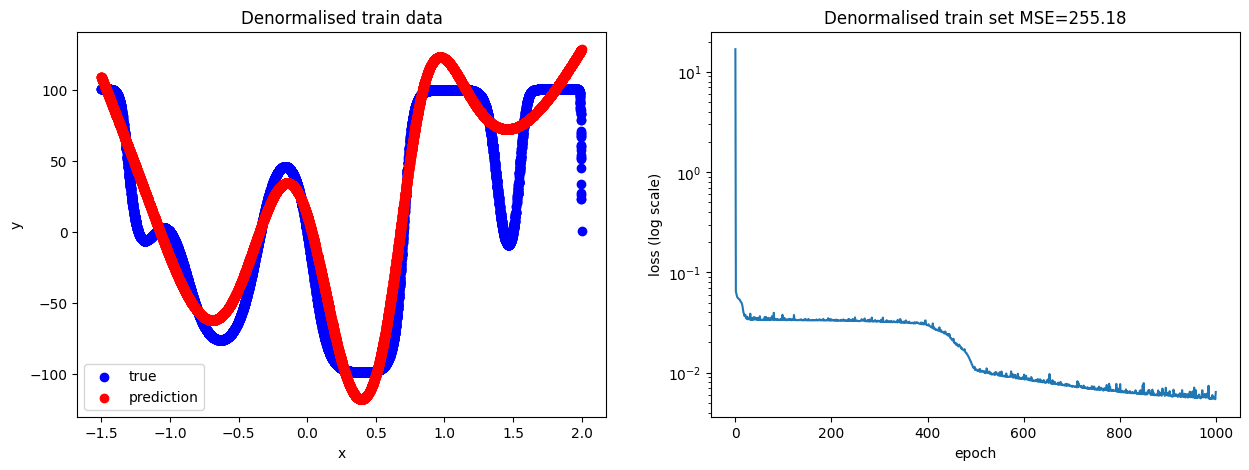

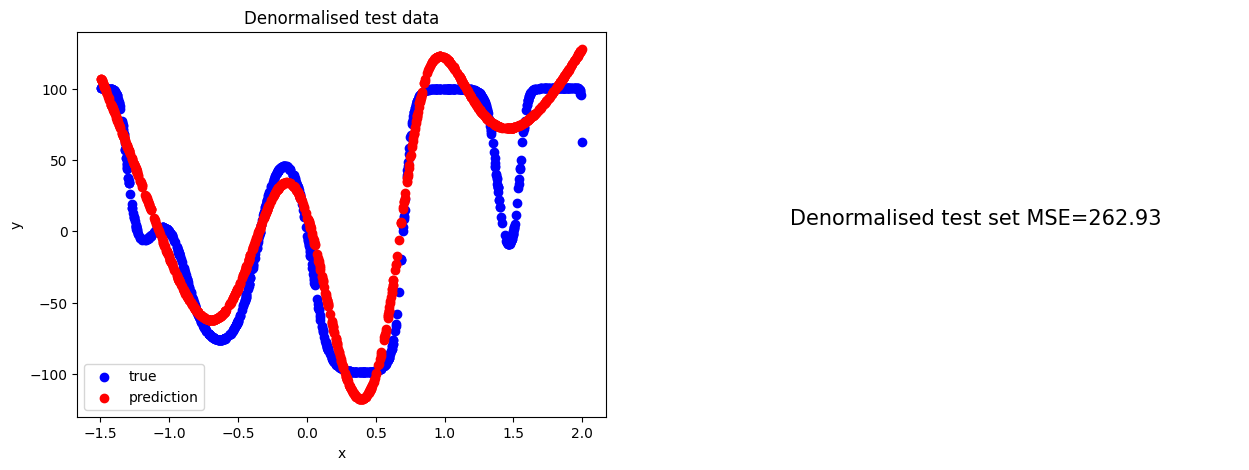

In [155]:
model = MLP([1, 10, 10, 1], 'sigmoid', out_act_fun_name='linear')
losses_mini, _, __ = train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, method = 'minibatch', first_lr = 0.3, lr_decay_rate = 0, epochs = 1000, n_epochs_displayed=1, batch_size=32)

## Batch

Epoch 1: loss_fun=0.14020665411557934
Epoch 2: loss_fun=0.06492002361444132
Epoch 3: loss_fun=0.06476961737462657
Epoch 4: loss_fun=0.06476934547093068
Epoch 5: loss_fun=0.06476925314263117
Epoch 6: loss_fun=0.06476916179940037
Epoch 7: loss_fun=0.06476907131795469
Epoch 8: loss_fun=0.06476898168215878
Epoch 9: loss_fun=0.06476889287634771
Epoch 10: loss_fun=0.0647688048852878
Epoch 11: loss_fun=0.06476871769416094
Epoch 12: loss_fun=0.0647686312885497
Epoch 13: loss_fun=0.06476854565442289
Epoch 14: loss_fun=0.06476846077812194
Epoch 15: loss_fun=0.06476837664634782
Epoch 16: loss_fun=0.06476829324614858
Epoch 17: loss_fun=0.06476821056490725
Epoch 18: loss_fun=0.06476812859033049
Epoch 19: loss_fun=0.06476804731043766
Epoch 20: loss_fun=0.06476796671355016
Epoch 21: loss_fun=0.06476788678828145
Epoch 22: loss_fun=0.0647678075235274
Epoch 23: loss_fun=0.064767728908457
Epoch 24: loss_fun=0.06476765093250347
Epoch 25: loss_fun=0.06476757358535579
Epoch 26: loss_fun=0.06476749685695041


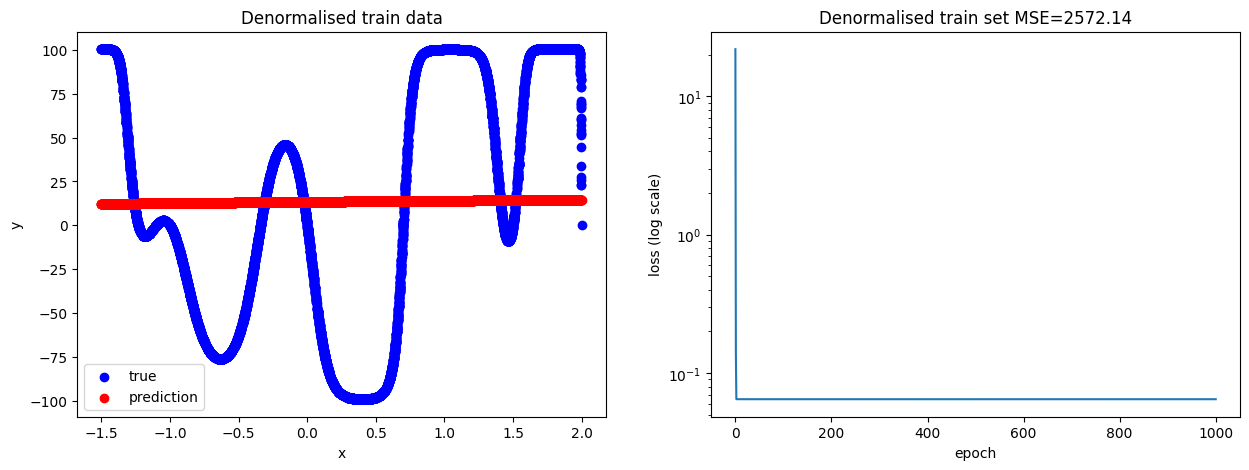

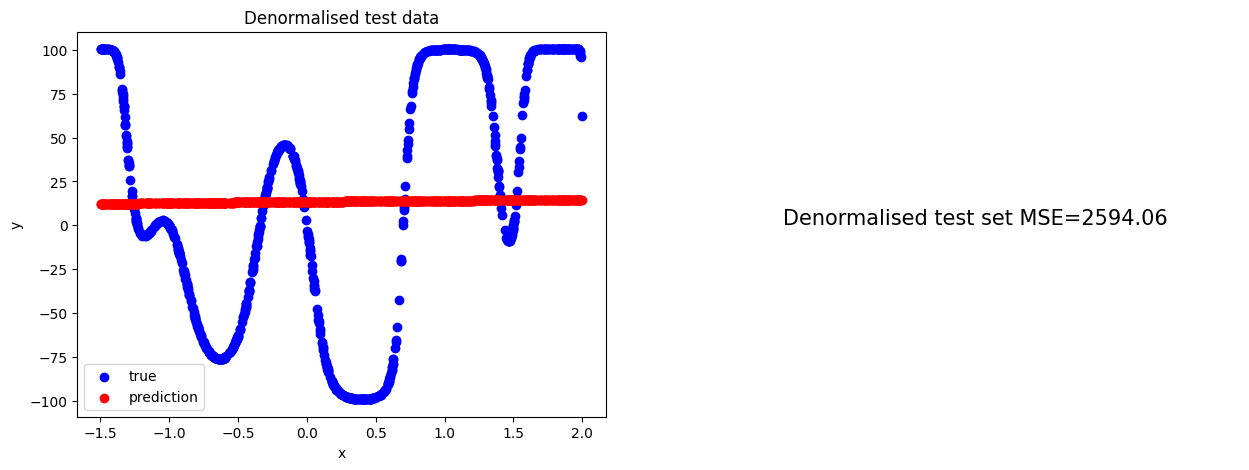

In [156]:
model = MLP([1, 10, 10, 1], 'sigmoid', out_act_fun_name='linear')
losses_batch, _, __ = train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, method = 'batch', first_lr = 0.1, lr_decay_rate = 1e-2, epochs = 1000, n_epochs_displayed=1)

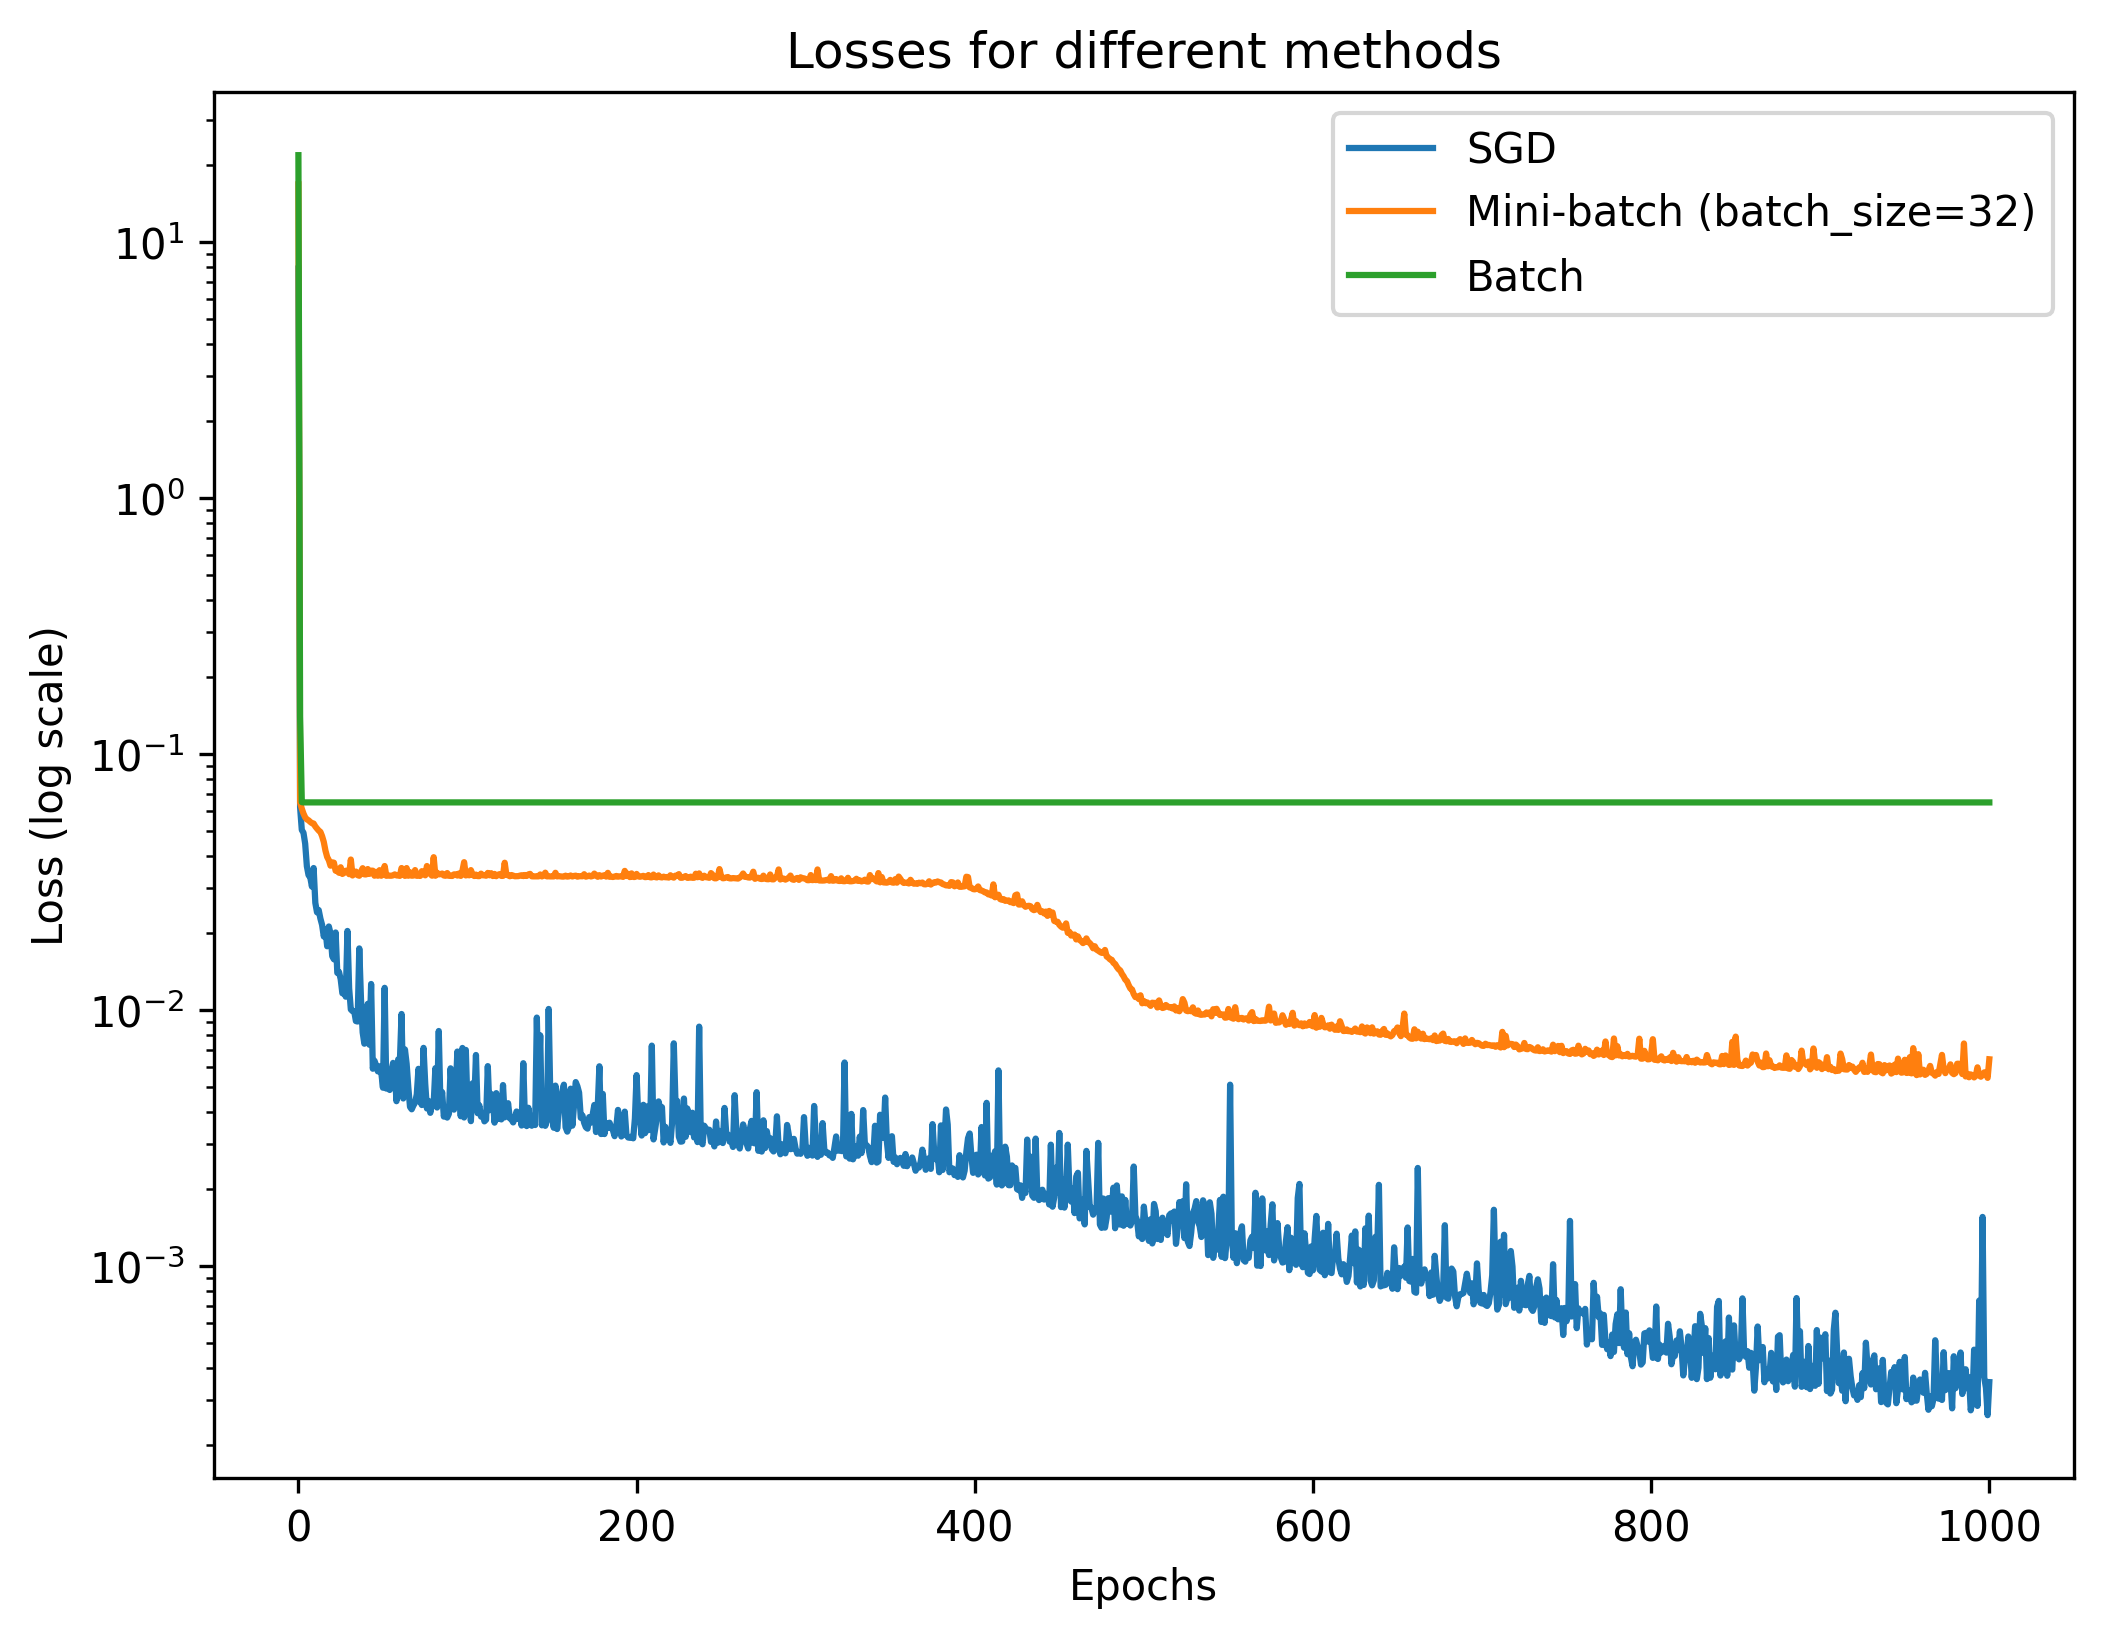

In [157]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

ax.plot(range(len(losses_sgd)), losses_sgd, label='SGD')
ax.plot(range(len(losses_mini)), losses_mini, label='Mini-batch (batch_size=32)')
ax.plot(range(len(losses_batch)), losses_batch, label='Batch')
ax.set_xlabel('Epochs')
ax.set_yscale('log')
ax.set_ylabel('Loss (log scale)')
ax.set_title('Losses for different methods')
ax.legend()
plt.show()